In [1]:
import torch
from torch.utils.data import DataLoader

from src.dataset.en_vi_dataset import EN_VIDataset
from src.models.model import Transformer
from src.utils.utils import input_target_collate_fn

import matplotlib.pyplot as plt
import traceback

In [2]:
dev = 'cpu'

In [3]:
# pretrained_path = 'checkpoints/Transformer-En2Vi-TPE-WordPiece-2021_07_22-08_53_23/best_bleu-bleu=0.154.pth'
pretrained_path = 'checkpoints/Transformer-En2Vi-TPE-WordPiece-2021_07_22-08_53_23/best_bleu-bleu=0.166.pth'
config = torch.load(pretrained_path, map_location=dev)

In [4]:
token_type = config['config']['dataset']['train']
token_type = token_type.get(
    'config', {'token_type': 'bpe'}).get('token_type', 'bpe')
data_cfg = {
    'src_path': 'data/en-vi/raw-data/test/tst2013.en',
    'trg_path': 'data/en-vi/raw-data/test/tst2013.vi',
}
if token_type == 'bpe':
    data_cfg.update({
        'token_type': 'bpe',
        'src_vocab': ["vocab/english_bpe/en-bpe-minfreq5-vocab.json",
                      "vocab/english_bpe/en-bpe-minfreq5-merges.txt"],
        'trg_vocab': ["vocab/vietnamese_bpe/vi-bpe-minfreq5-vocab.json",
                      "vocab/vietnamese_bpe/vi-bpe-minfreq5-merges.txt"],
        # src_vocab: ["vocab/shared/shared-vocab.json", "vocab/shared/shared-merges.txt"]
        # trg_vocab: ["vocab/shared/shared-vocab.json", "vocab/shared/shared-merges.txt"]
    })
elif token_type == 'wordpiece':
    data_cfg.update({
        'token_type': 'wordpiece',
        'src_vocab': 'vocab/english_word/en-wordpiece-minfreq5-vocab.txt',
        'trg_vocab': 'vocab/vietnamese_word/vi-wordpiece-minfreq5-vocab.txt',
    })
ds = EN_VIDataset(**data_cfg)
dl = DataLoader(ds, batch_size=2,
                collate_fn=input_target_collate_fn)

In [5]:
TRG_EOS_TOKEN = '</s>'
TRG_EOS_ID = ds.vi_tokenizer.token_to_id(TRG_EOS_TOKEN)

In [6]:
model = Transformer(
    n_src_vocab=ds.en_tokenizer.get_vocab_size(),
    n_trg_vocab=ds.vi_tokenizer.get_vocab_size(),
    src_pad_idx=ds.en_tokenizer.token_to_id('<pad>'),
    trg_pad_idx=ds.vi_tokenizer.token_to_id('<pad>'),
    **config['config']['model']
).to(dev)
model.load_state_dict(config['model_state_dict'])
model.eval()
print()

# **Visualize attention**

In [7]:
def visualize_attn(attn, dsts, ques):
    for j, (b, dst, que) in enumerate(zip(attn, dsts, ques)):
        print(f'===== Input {j} =====')
        fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
        ax.imshow(b.mean(0).detach().cpu())
        
        ax.set_xticks(range(len(dst)))
        ax.set_xticklabels(dst)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax.set_yticks(range(len(que)))
        ax.set_yticklabels(que)
        plt.show()

In [8]:
@torch.no_grad()
def make_prediction(i, src, trg):
    src = src.to(dev)
    trg = trg.to(dev)

    src_ = src.cpu().numpy()
    src_tokens = [[ds.en_tokenizer.id_to_token(ss) for ss in s] for s in src_]
    src_ = ds.en_tokenizer.decode_batch(src_)
    # print('Source', src_tokens)

    trg_ = trg.cpu().numpy()
    trg_tokens = [[ds.vi_tokenizer.id_to_token(ss) for ss in s] for s in trg_]
    # trg_ = ds.vi_tokenizer.decode_batch(trg_)
    # print('Target', trg_tokens)

    pred = model(src, trg[:, :-1])
    pred_ = pred.argmax(-1).cpu().numpy()
    pred_tokens = [[ds.vi_tokenizer.id_to_token(ss) for ss in s] for s in pred_]
    # pred_ = ds.vi_tokenizer.decode_batch(pred_)
    # print('Prediction', pred_tokens)

    return src_tokens, trg_tokens, pred_tokens

In [9]:
def visualize_attn_hook(m, i, o):
    global attn
    try:
        attn = o[1]
    except:
        traceback.print_exc()
        handle.remove()
    handle.remove()

## **Encoder self-attention**

Layer 0
===== Input 0 =====


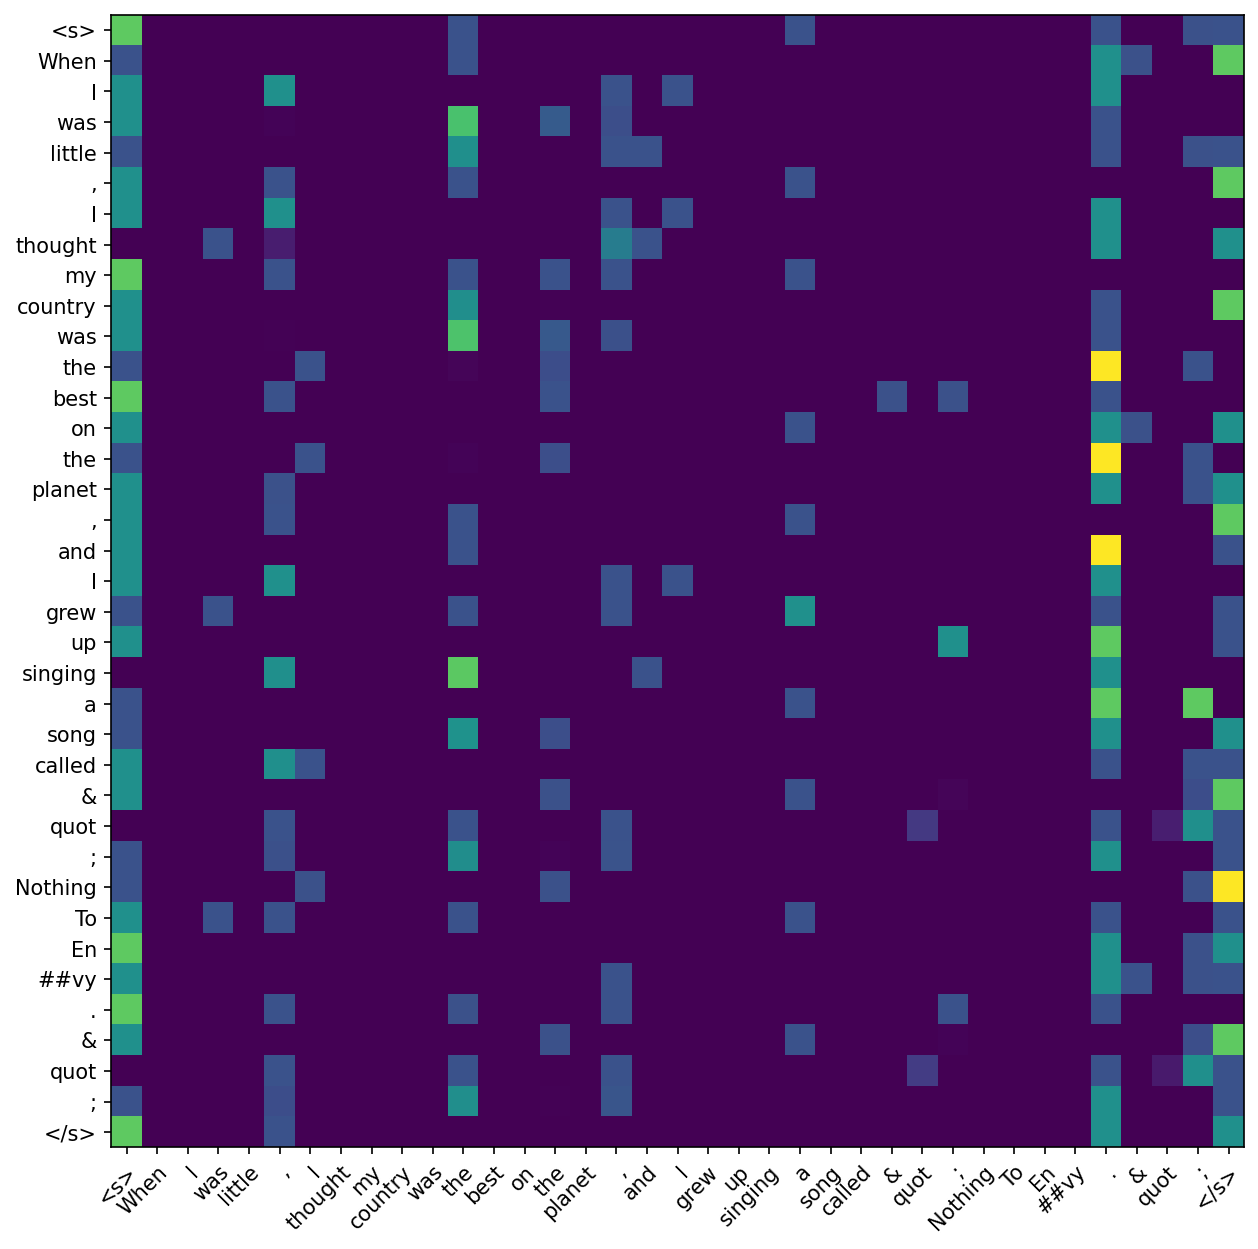

===== Input 1 =====


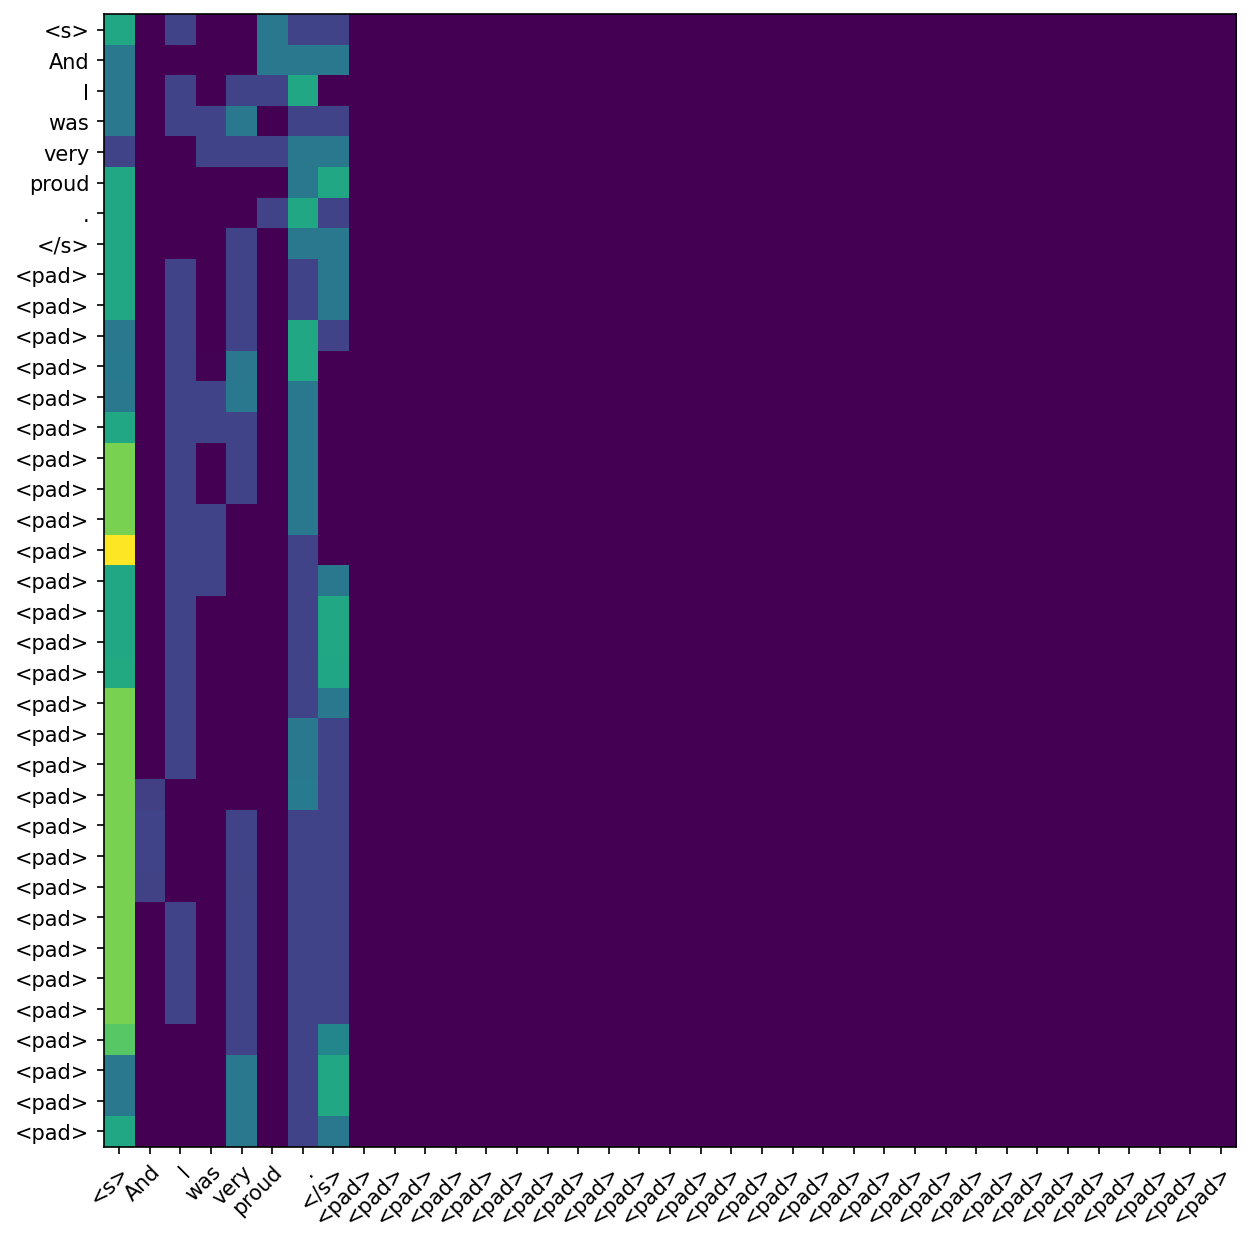

Layer 1
===== Input 0 =====


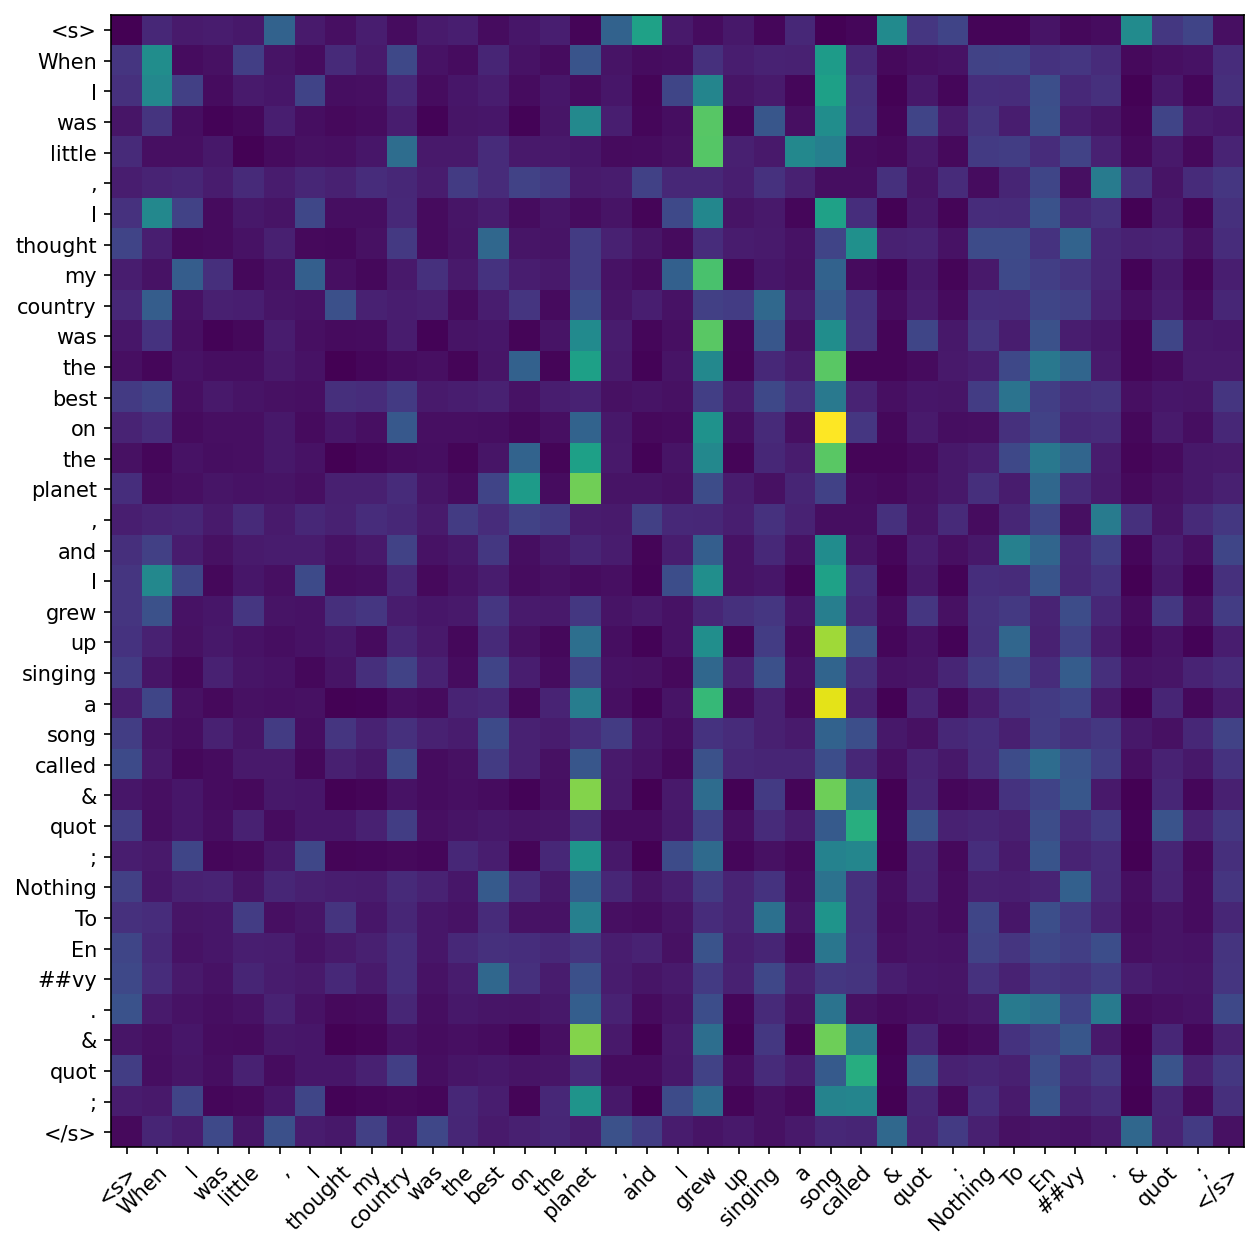

===== Input 1 =====


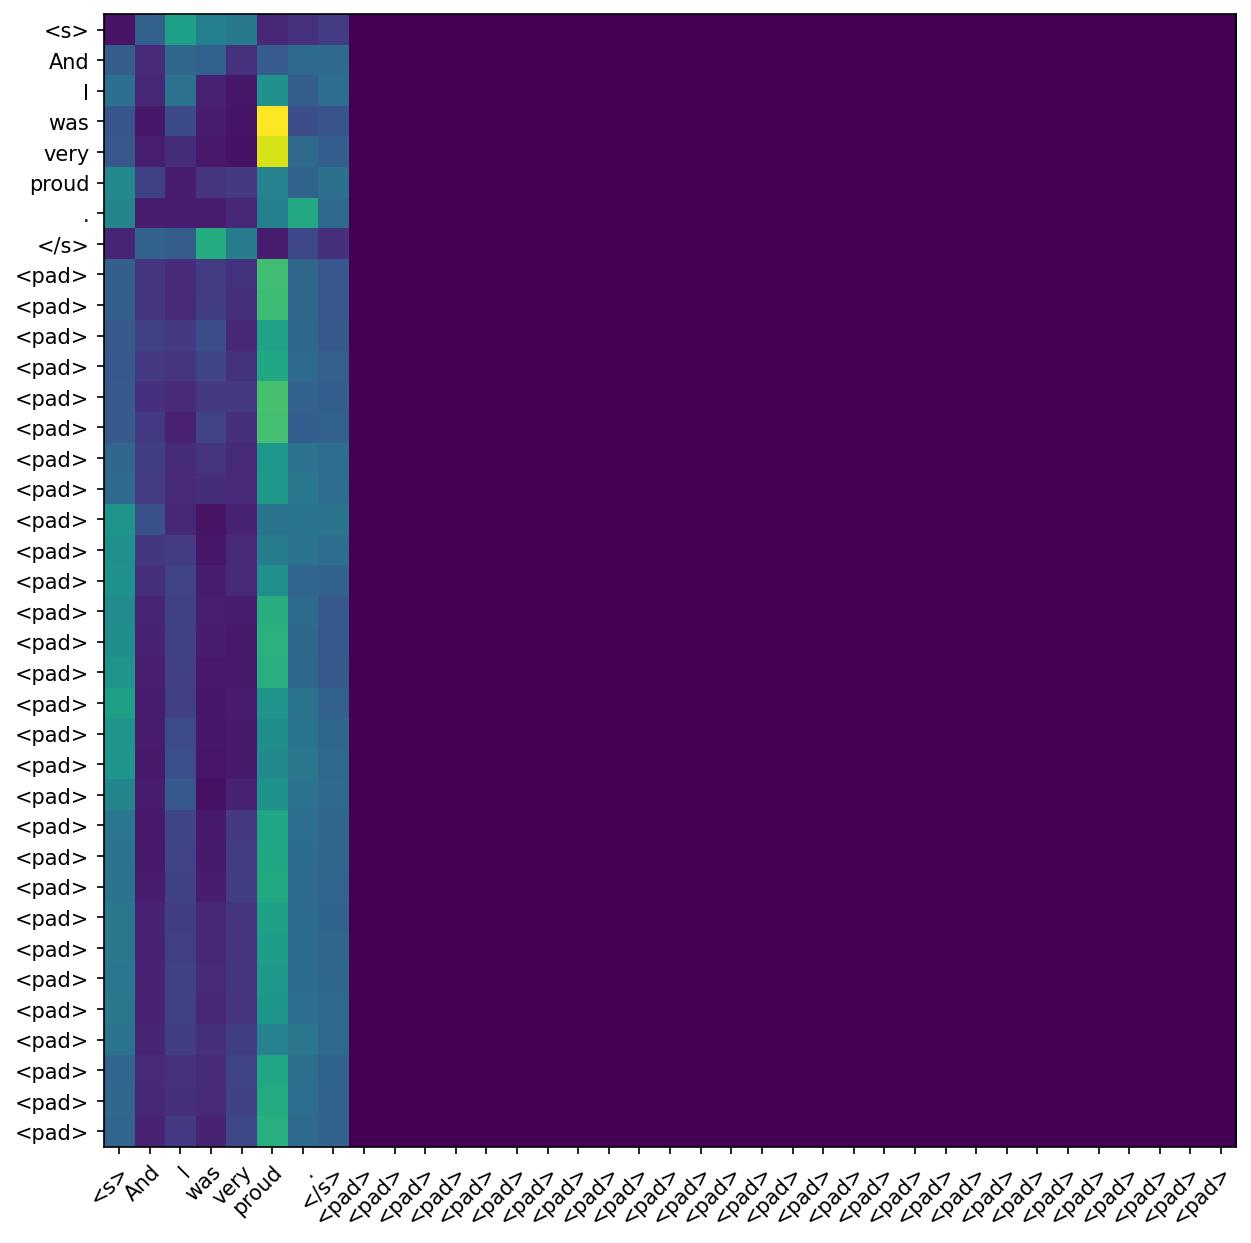

Layer 2
===== Input 0 =====


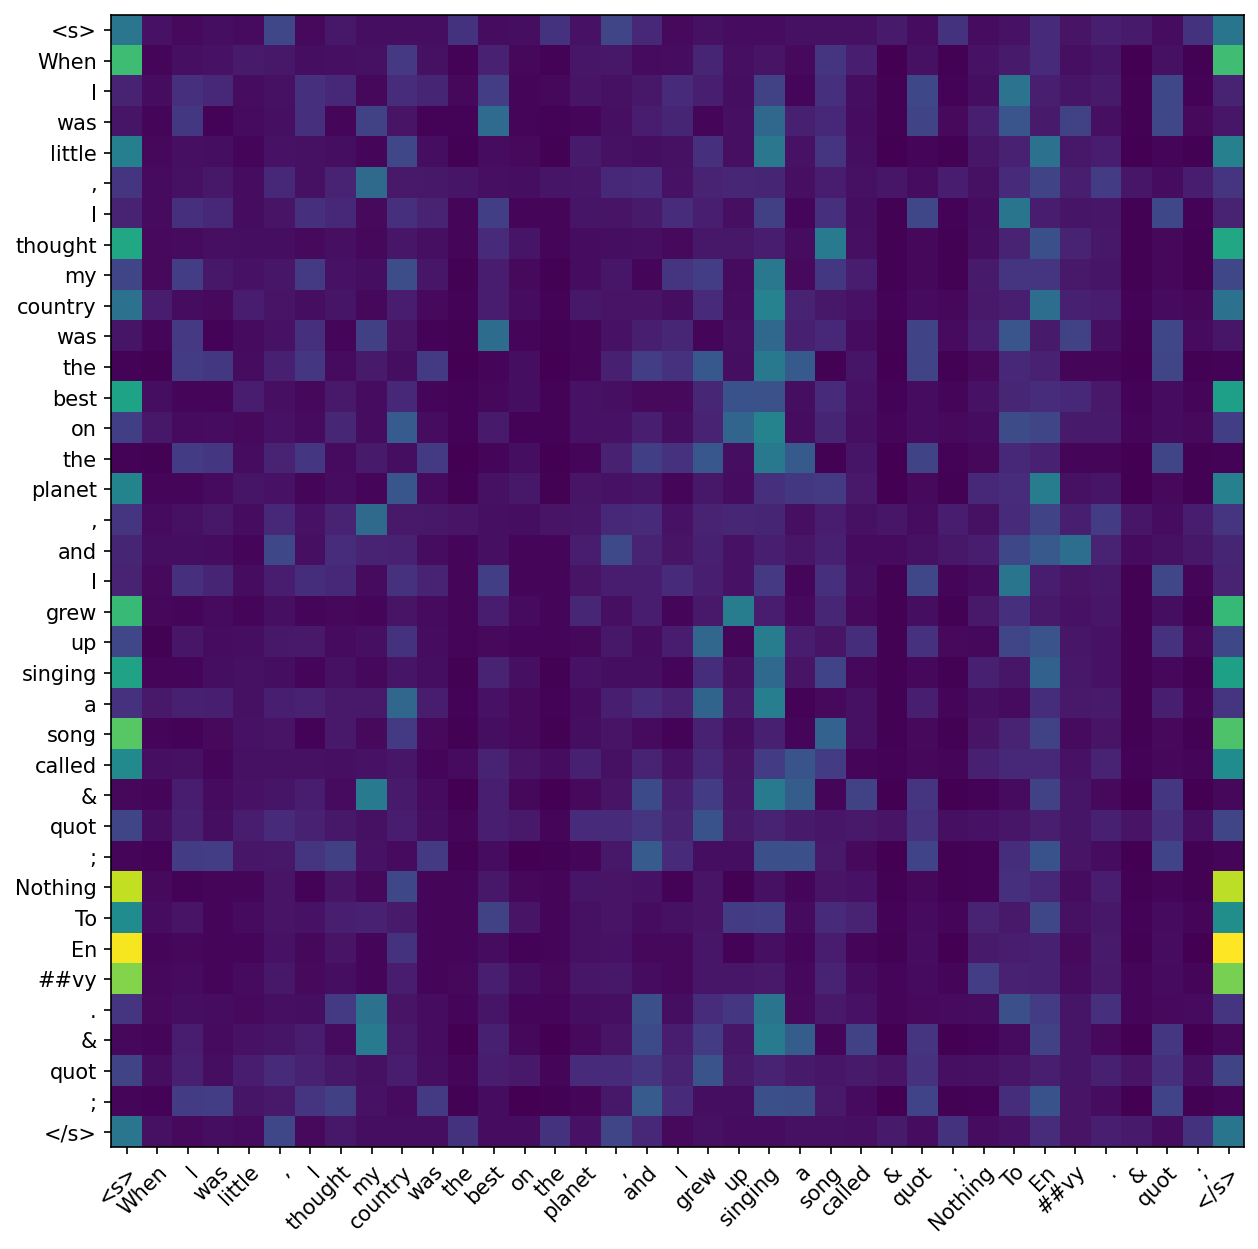

===== Input 1 =====


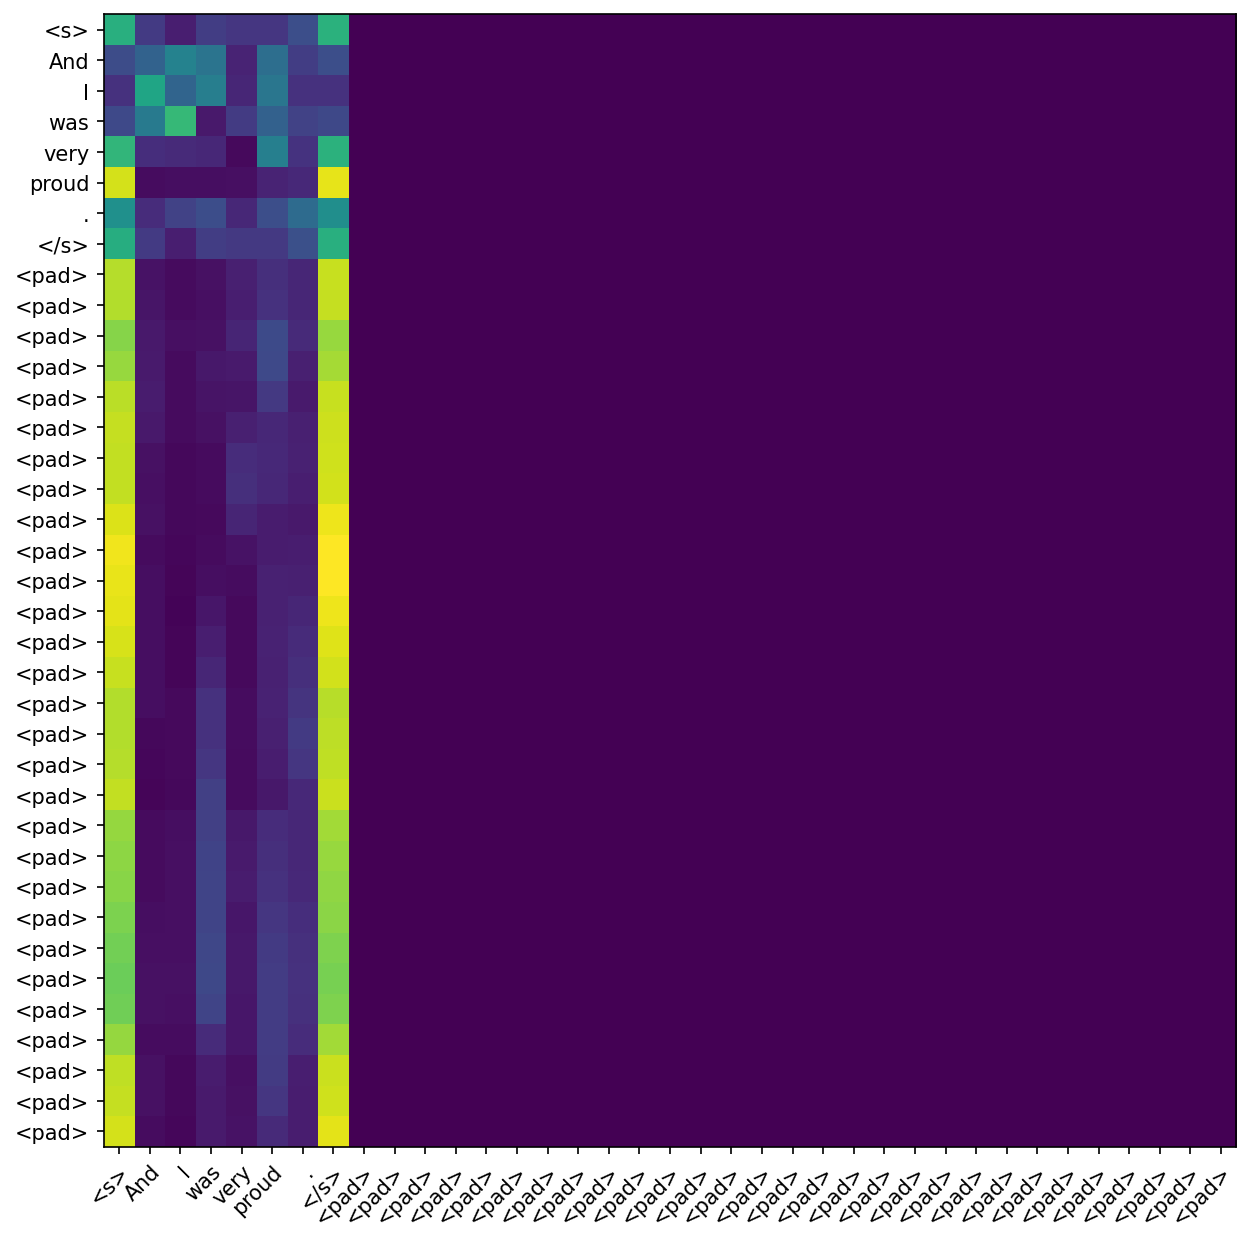

Layer 3
===== Input 0 =====


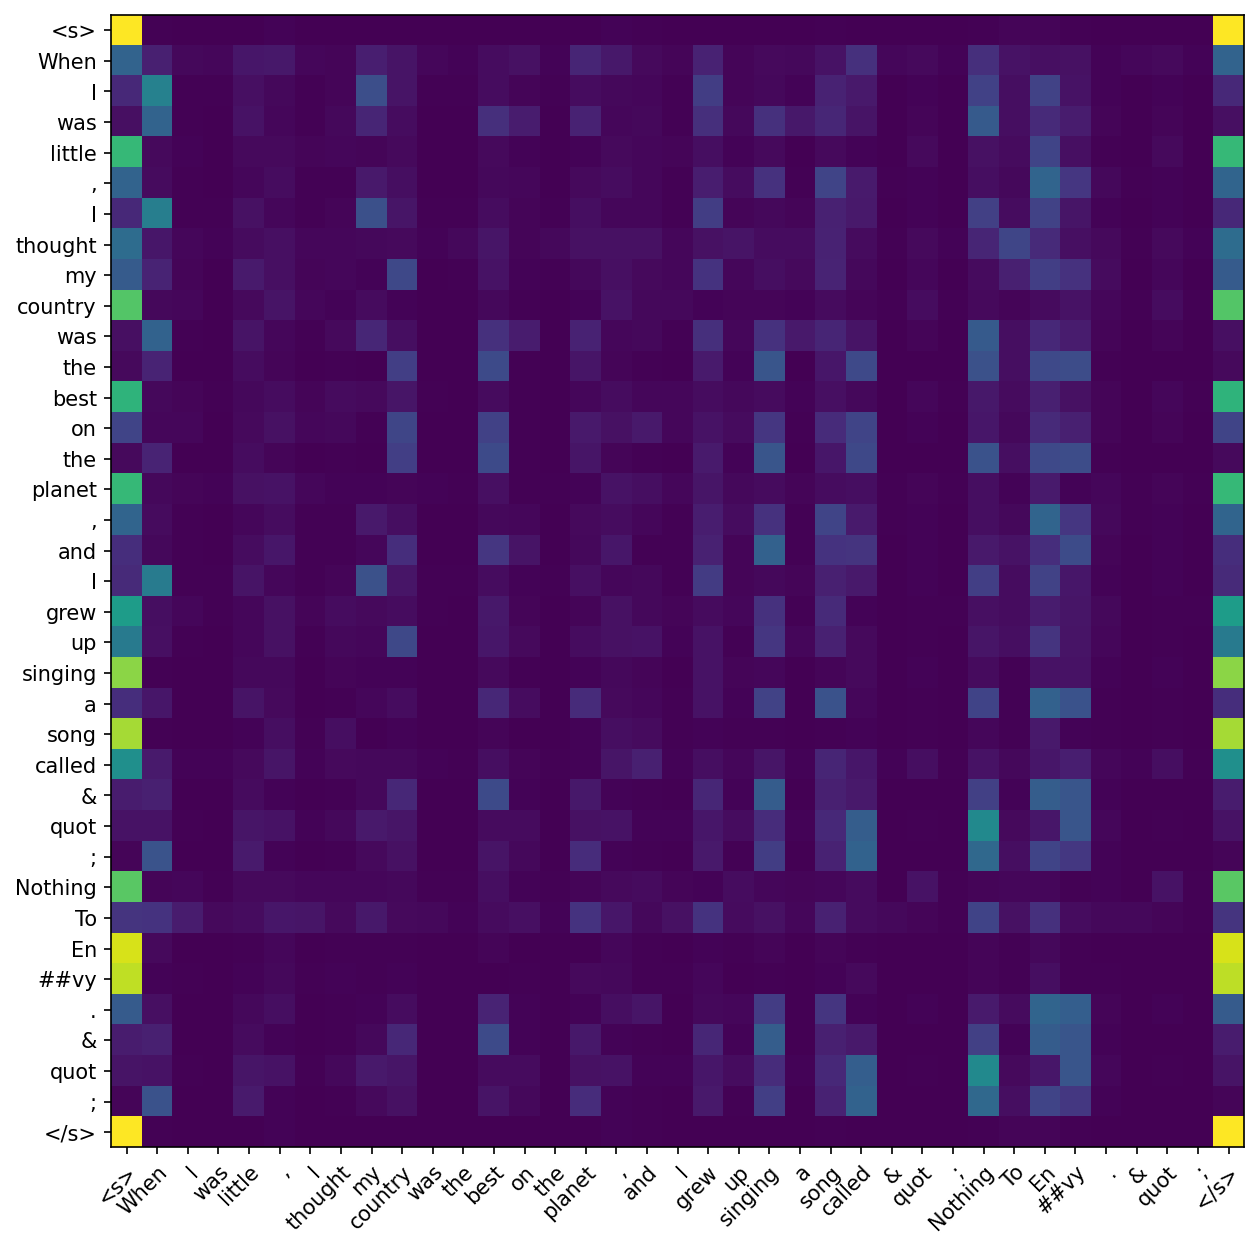

===== Input 1 =====


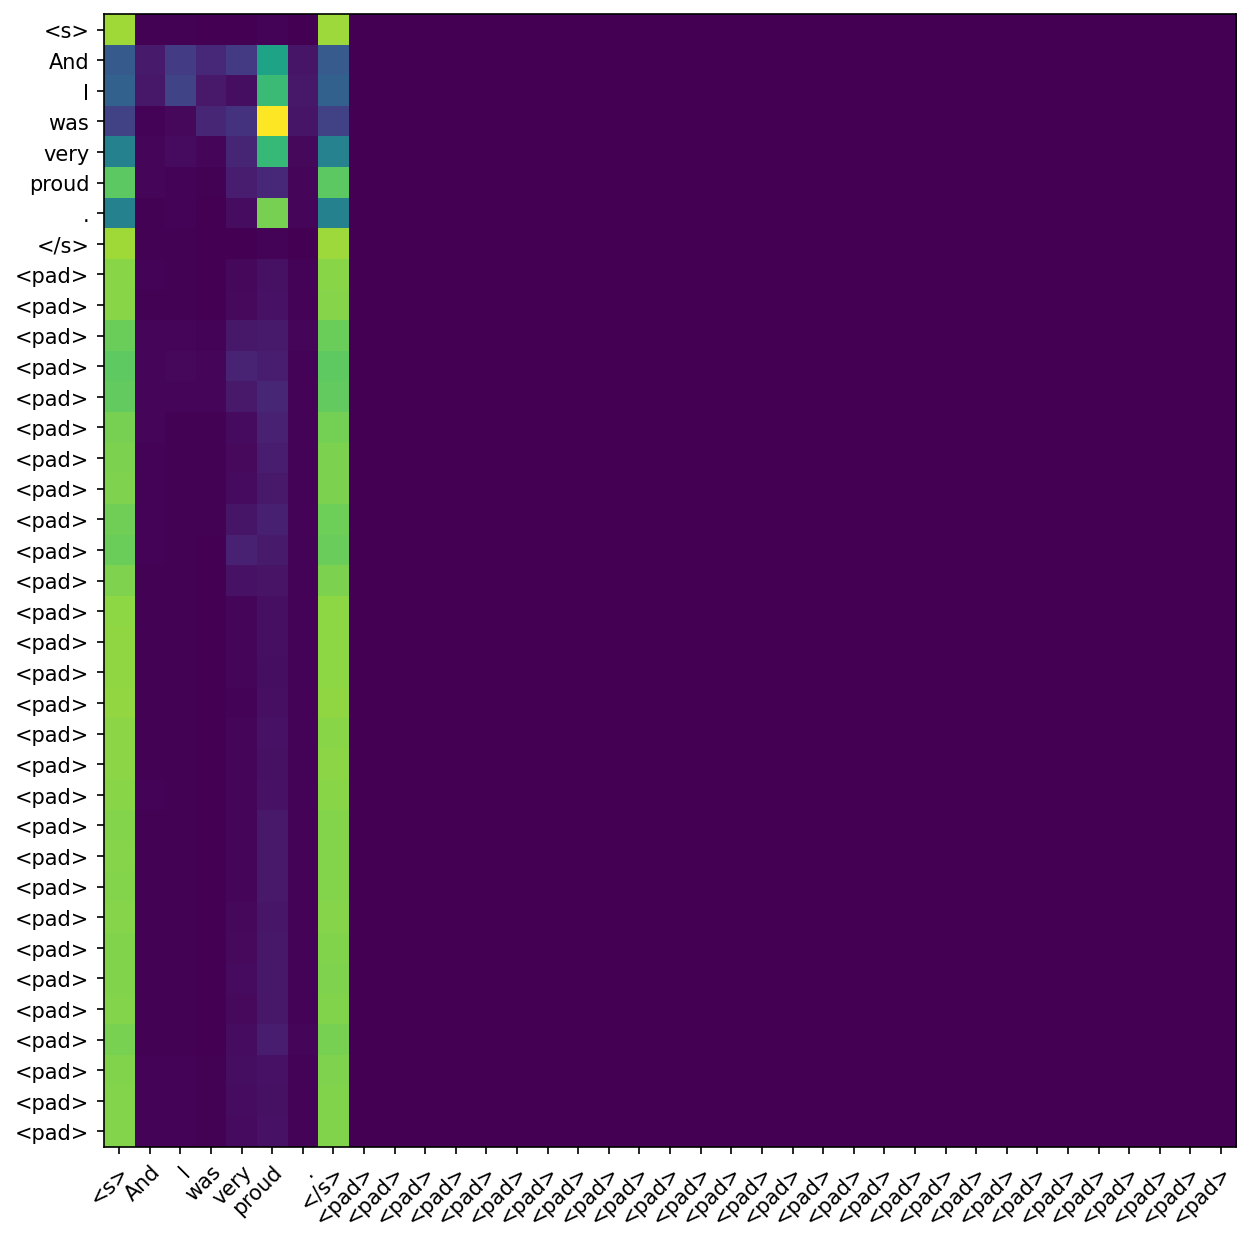

Layer 4
===== Input 0 =====


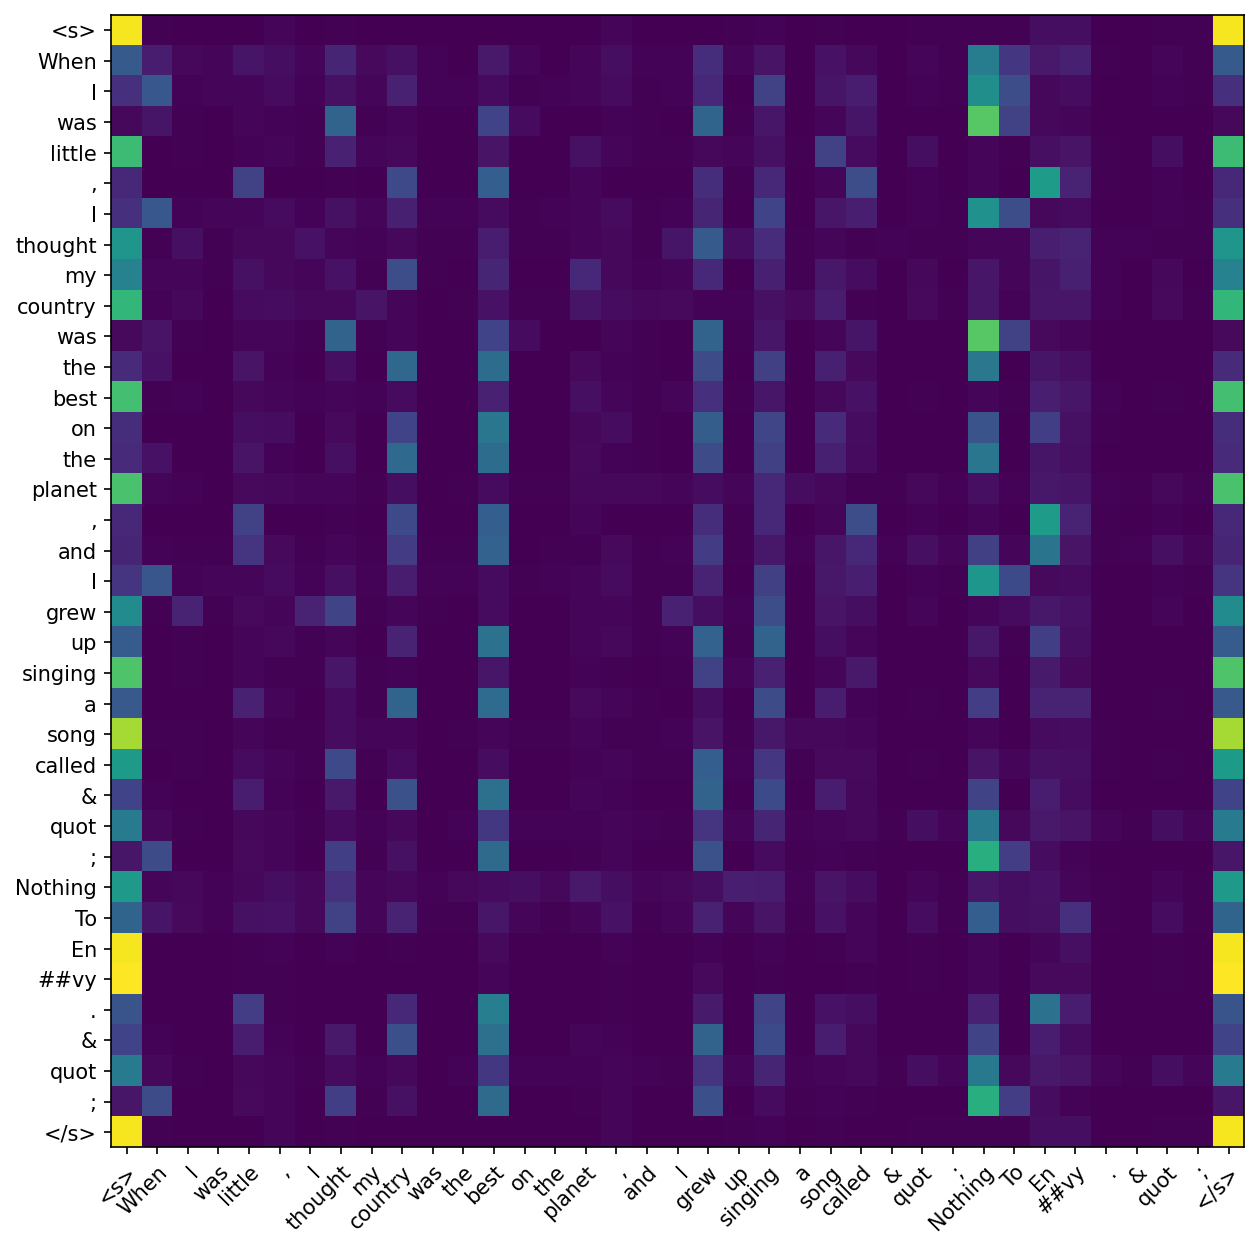

===== Input 1 =====


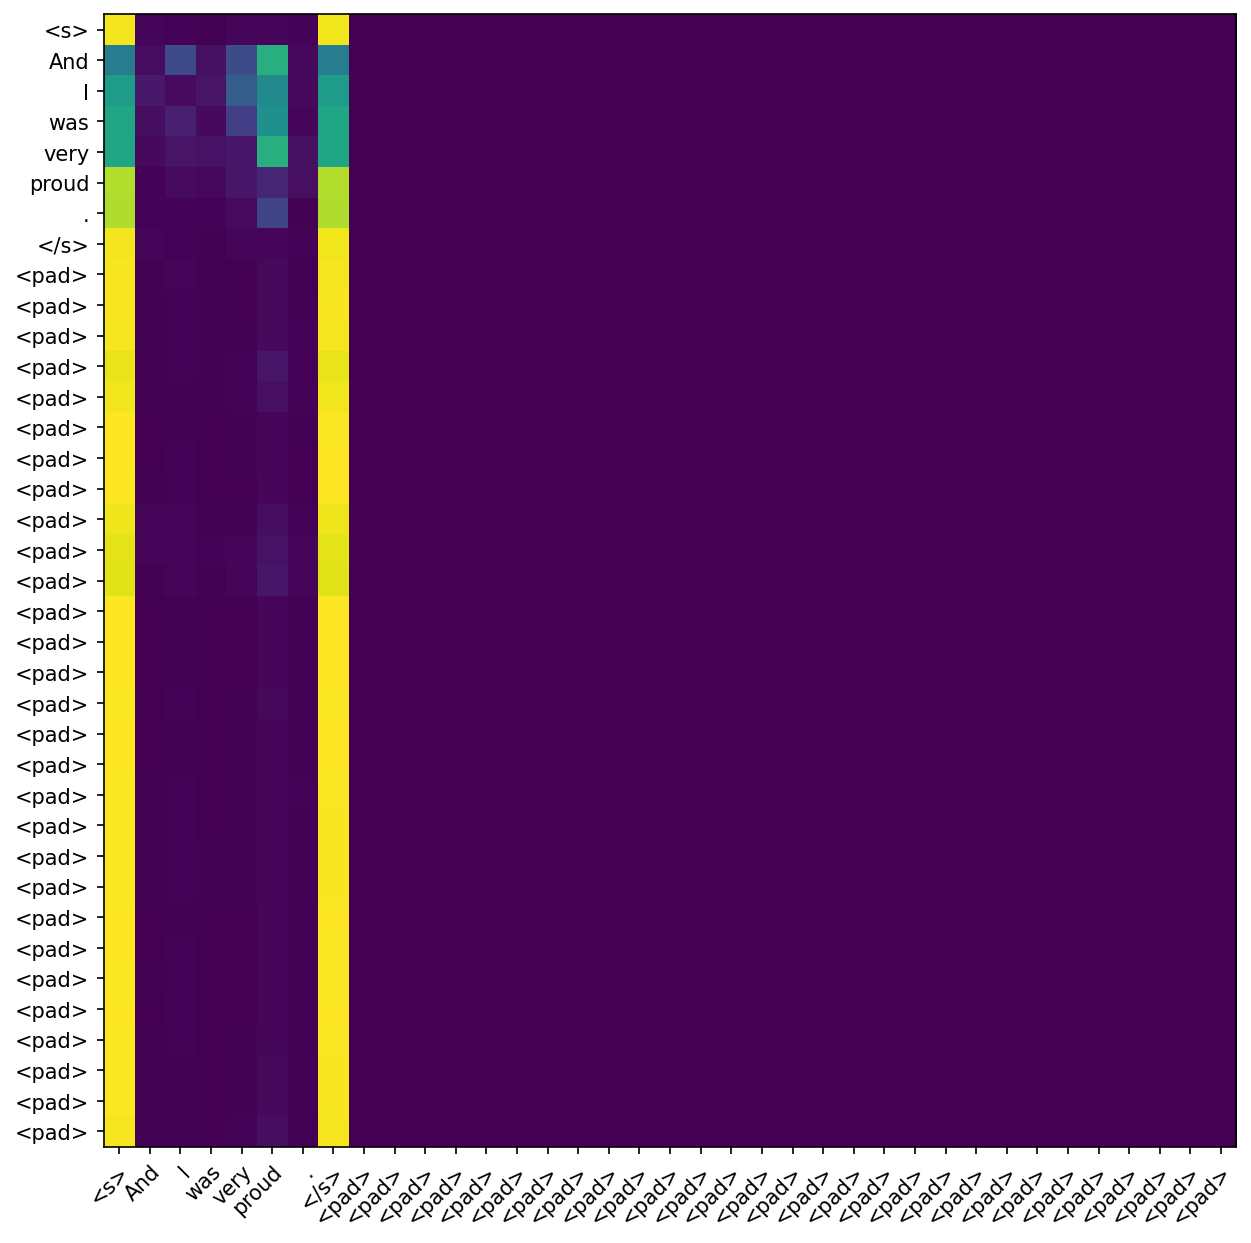

Layer 5
===== Input 0 =====


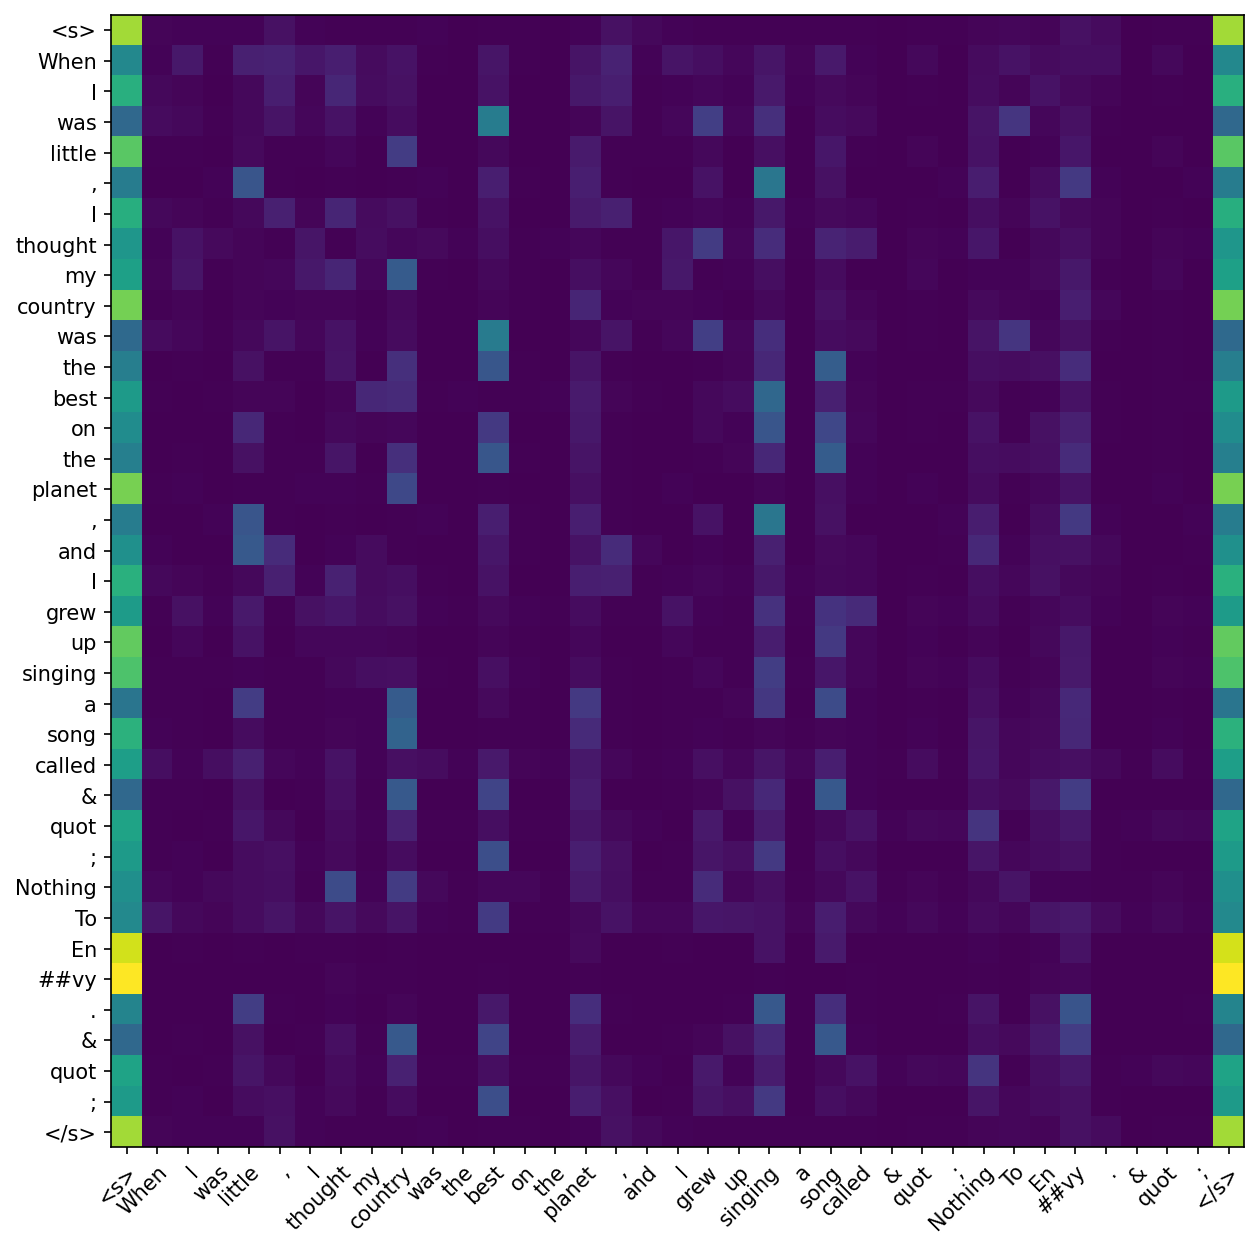

===== Input 1 =====


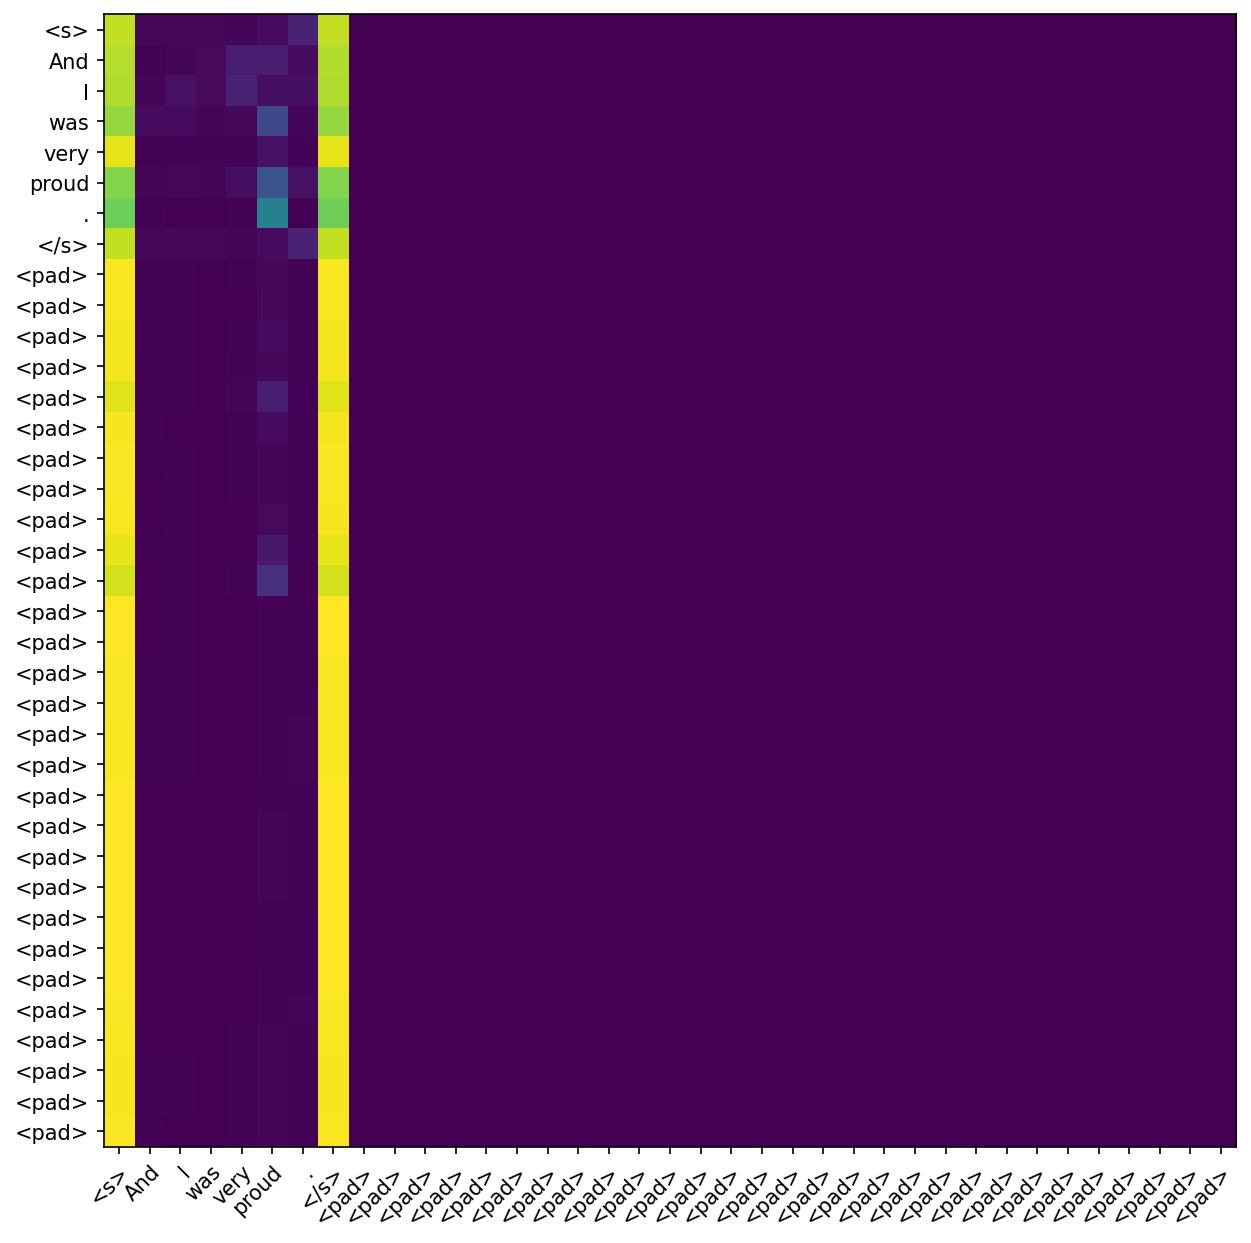

In [10]:
for l in range(len(model.encoder.layer_stack)):
    print(f'Layer {l}')

    handle = model.encoder.layer_stack[l].self_attn.attention.register_forward_hook(visualize_attn_hook)

    for i, (src, trg) in enumerate(dl):
        attn = None
        src_tokens, trg_tokens, pred_tokens = make_prediction(i, src, trg)
        visualize_attn(attn, src_tokens, src_tokens)
        break

## **Decoder self-attention**

Layer 0
===== Input 0 =====


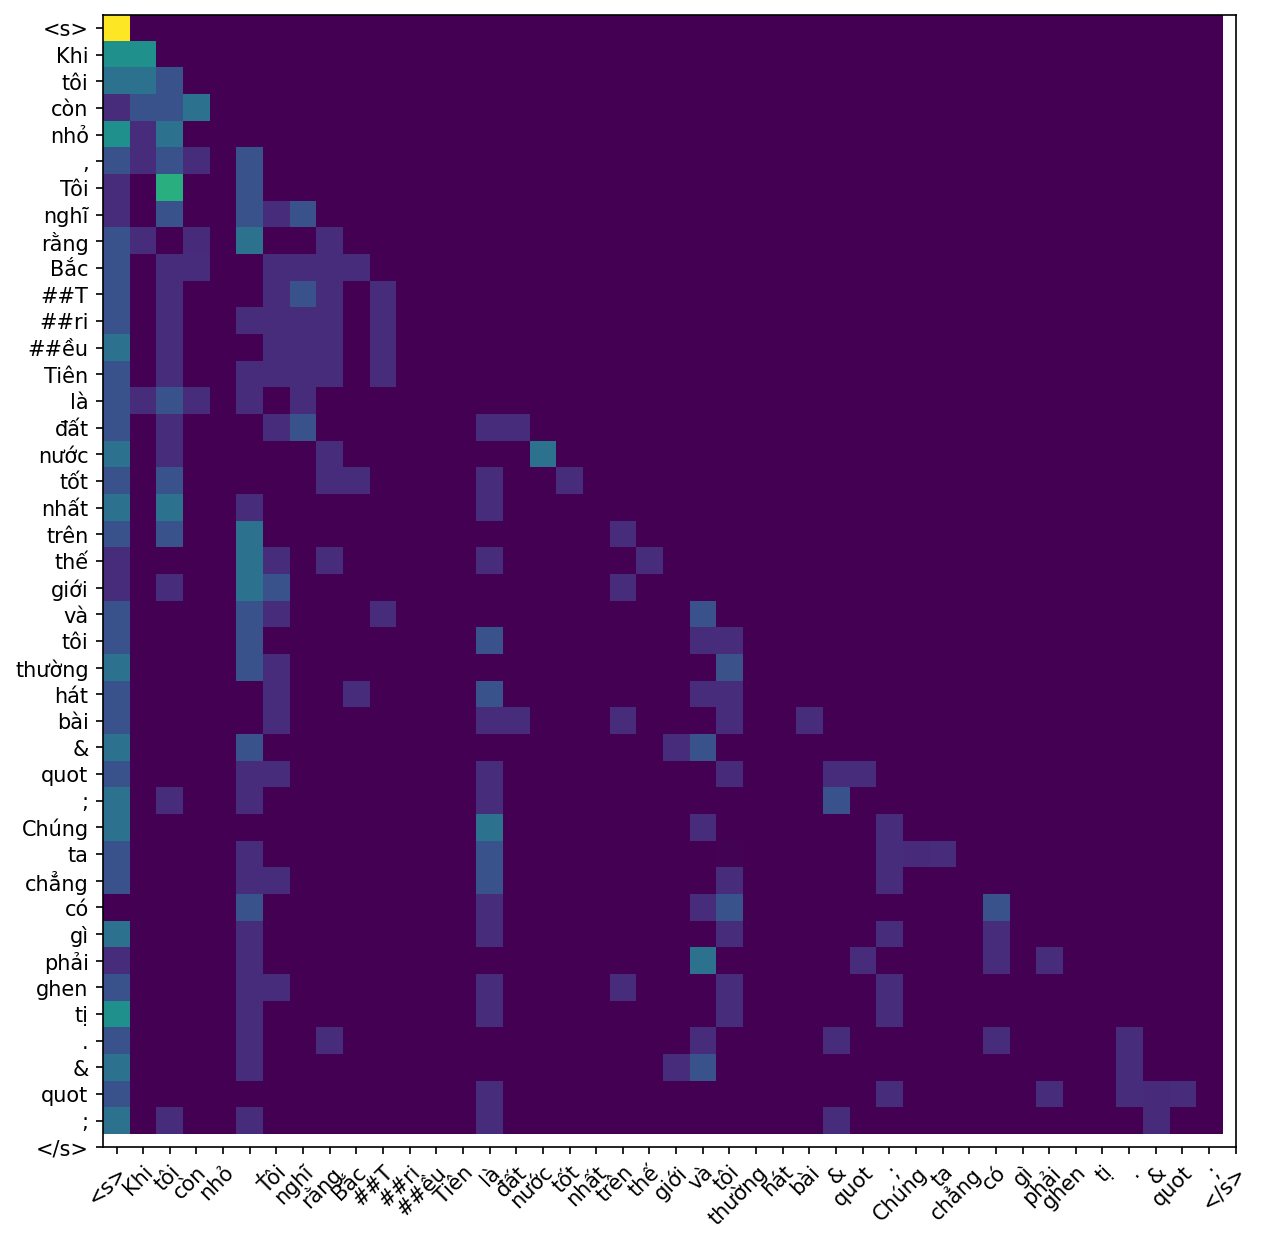

===== Input 1 =====


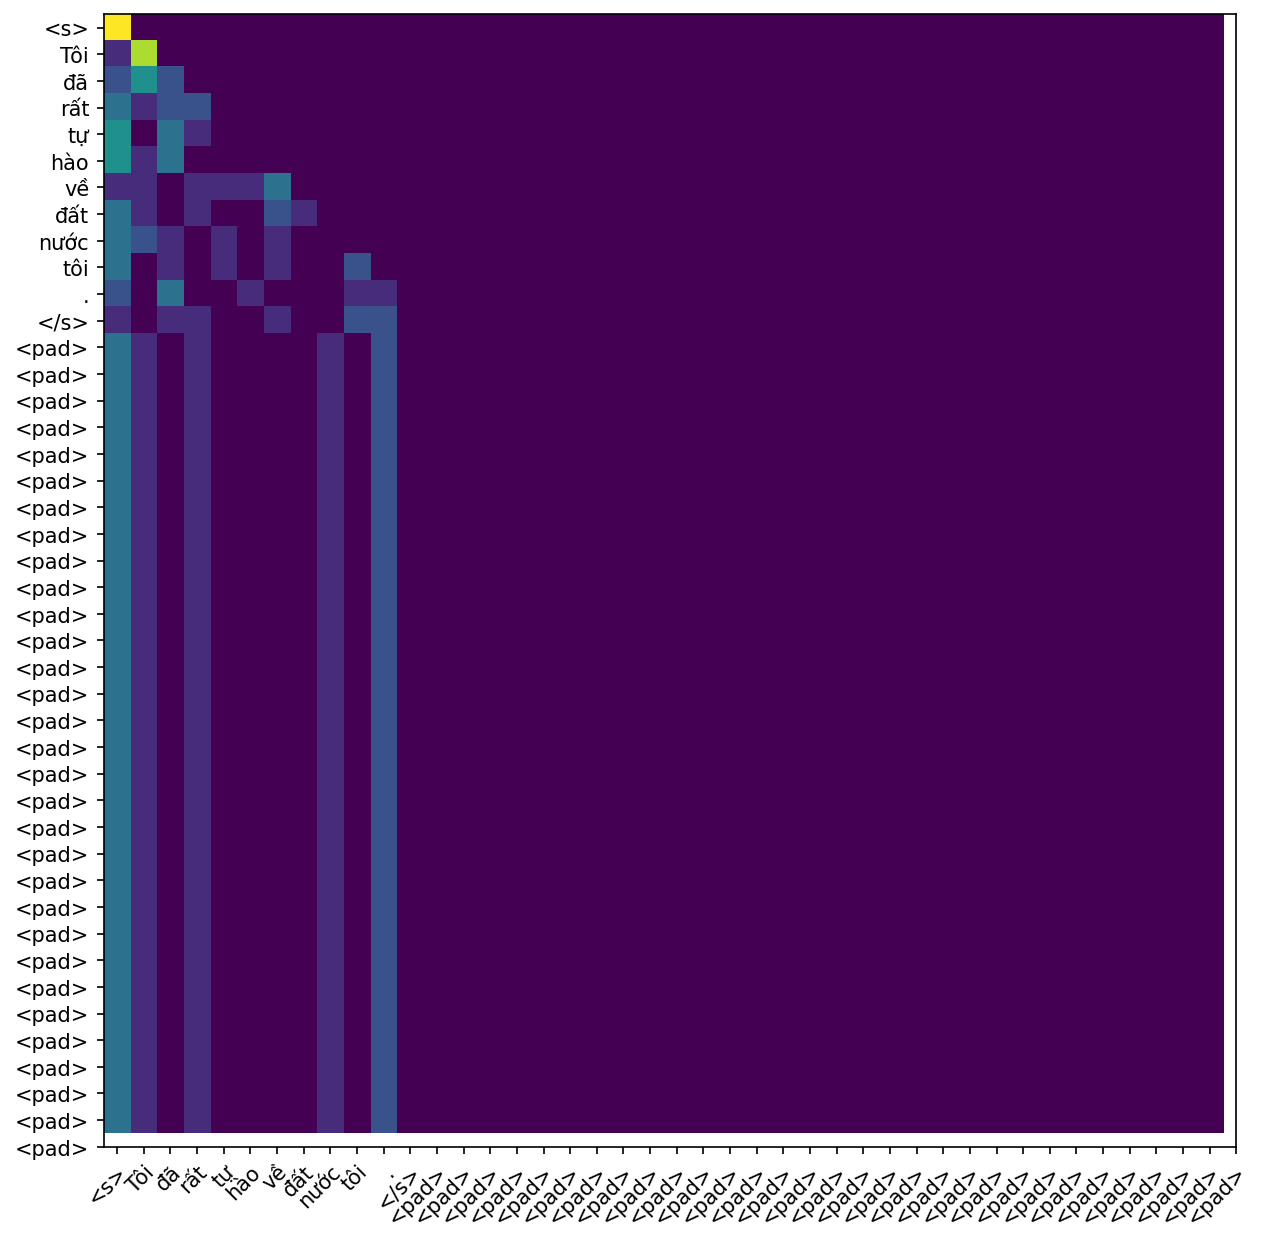

Layer 1
===== Input 0 =====


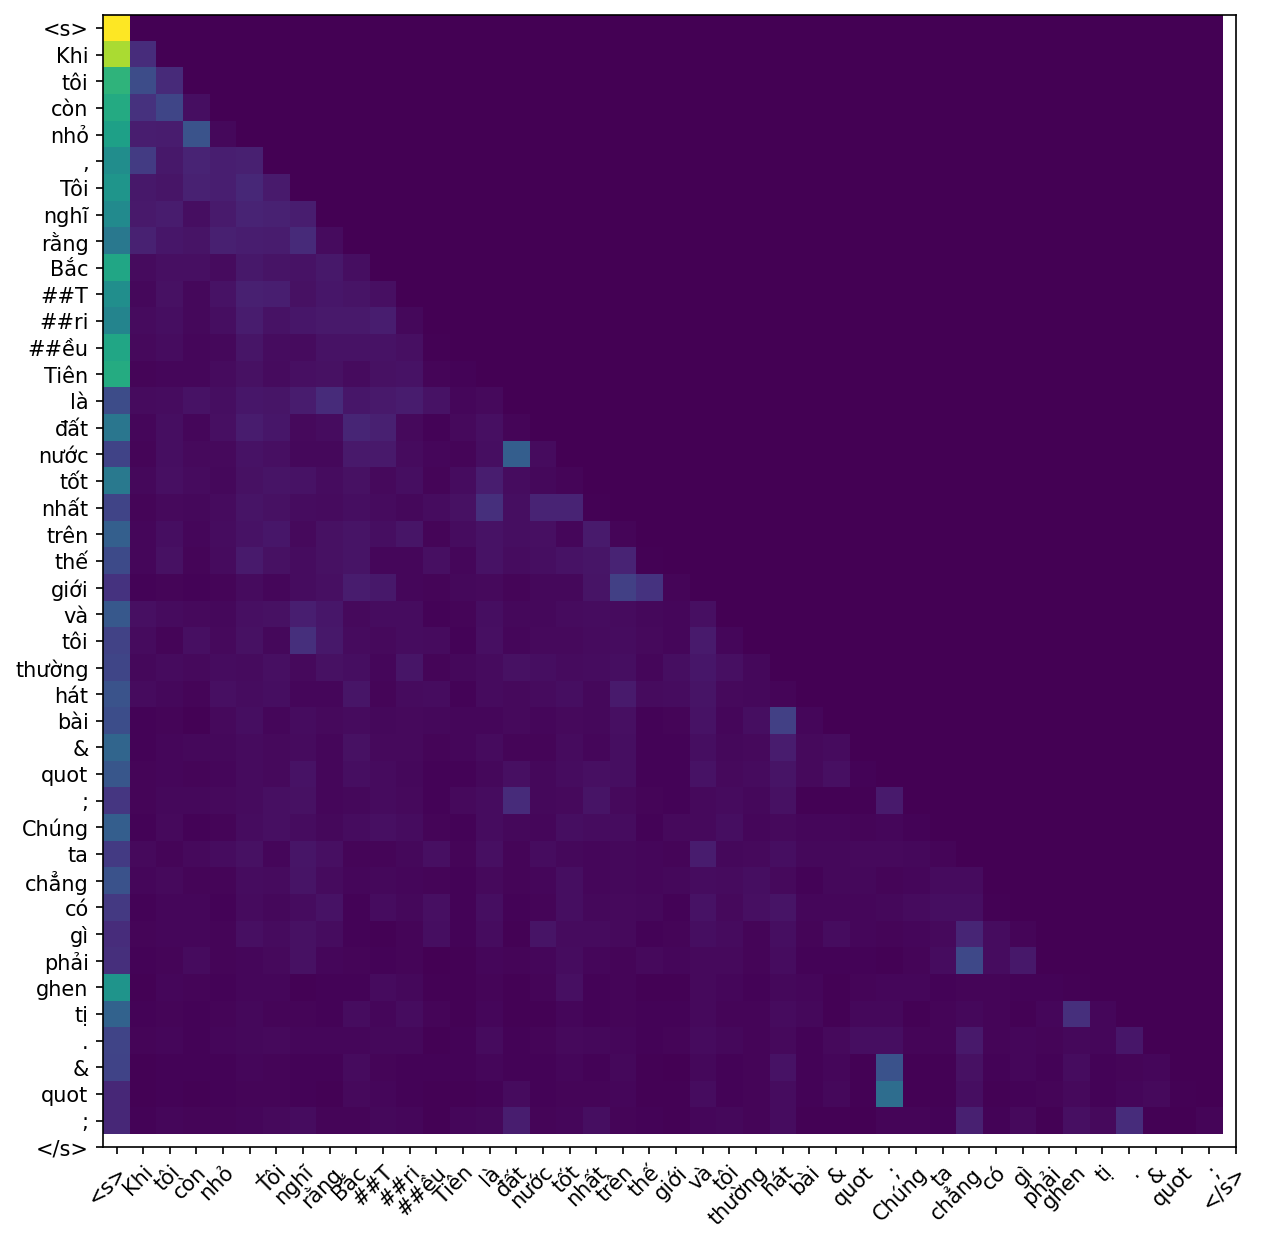

===== Input 1 =====


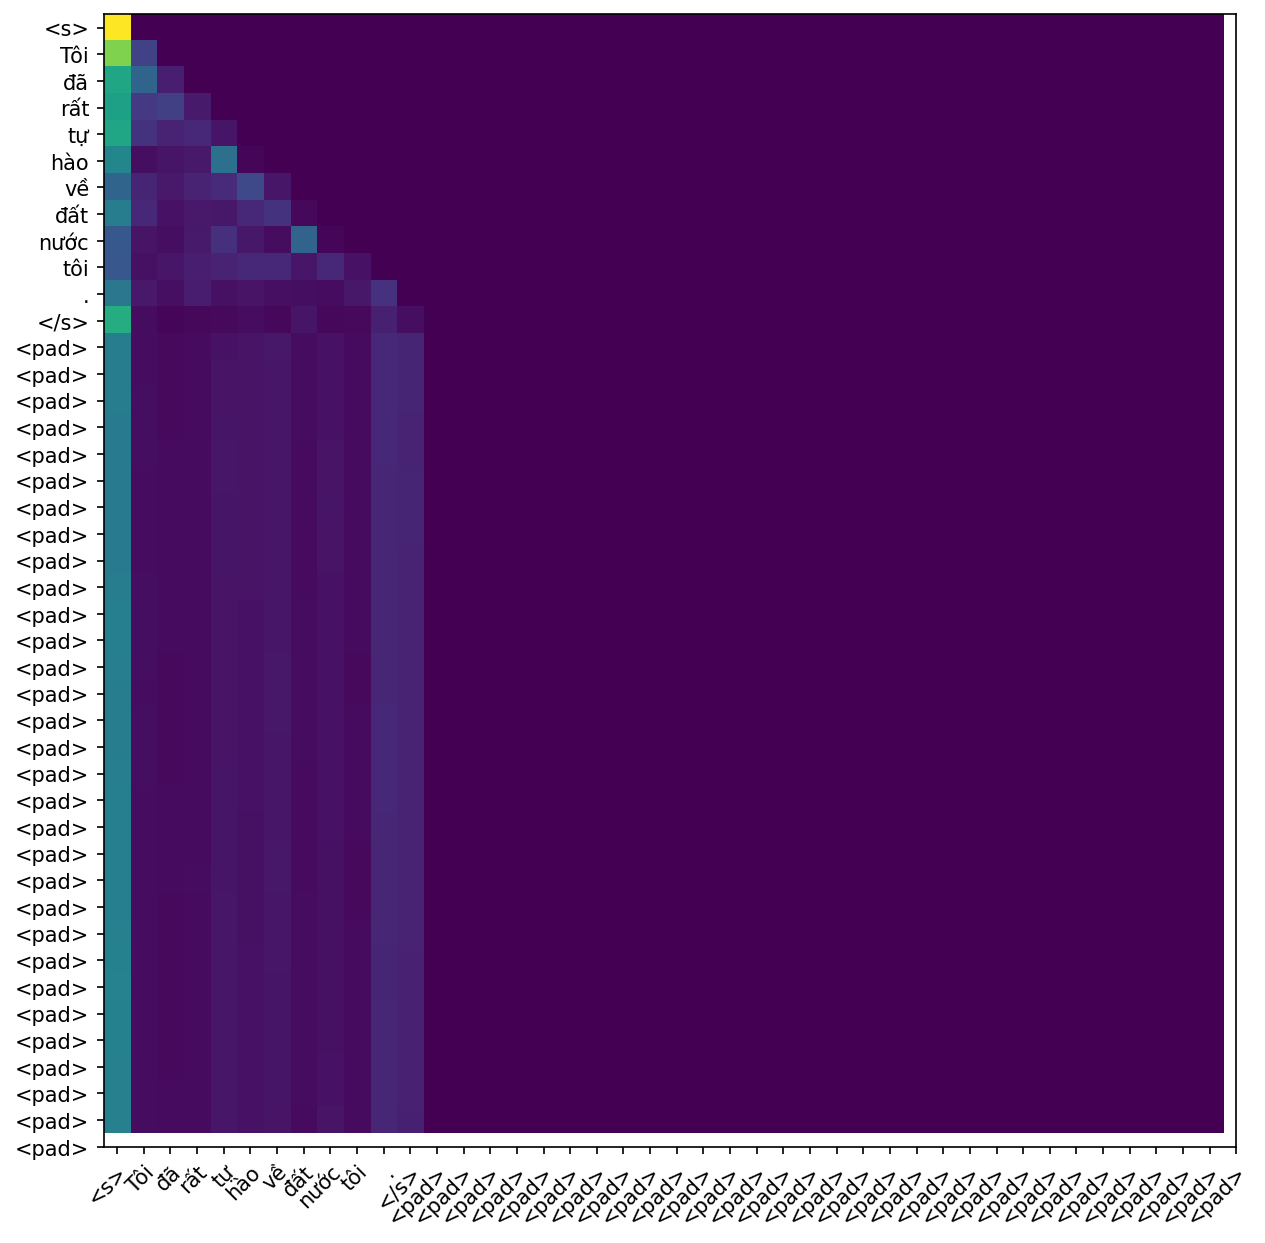

Layer 2
===== Input 0 =====


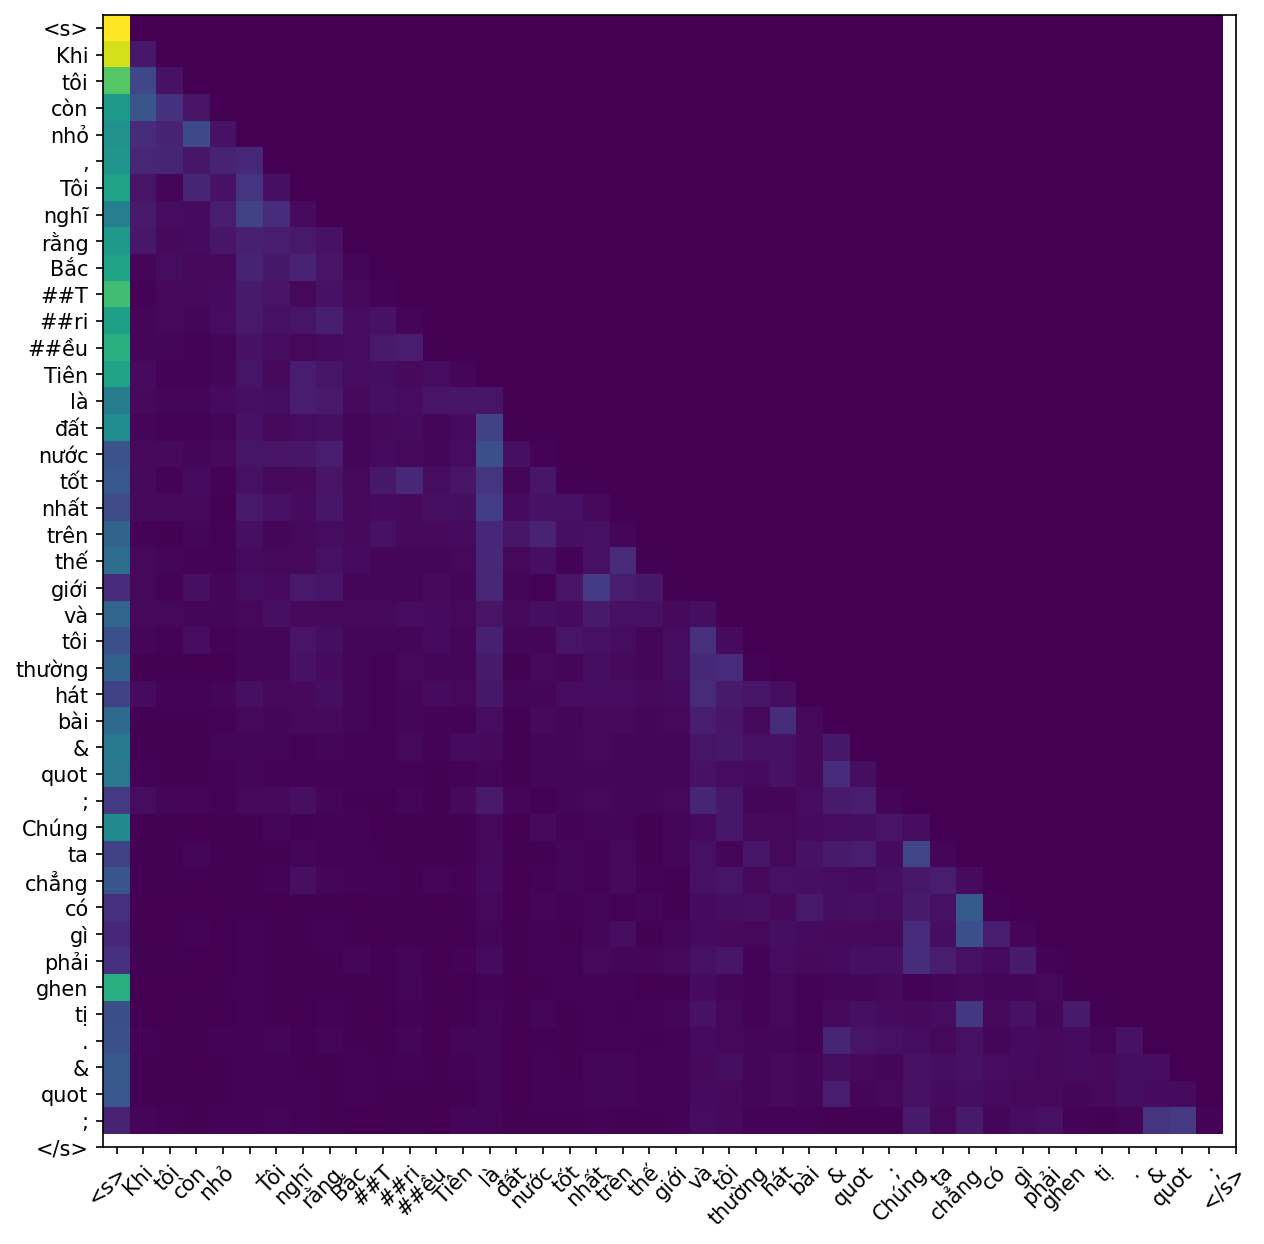

===== Input 1 =====


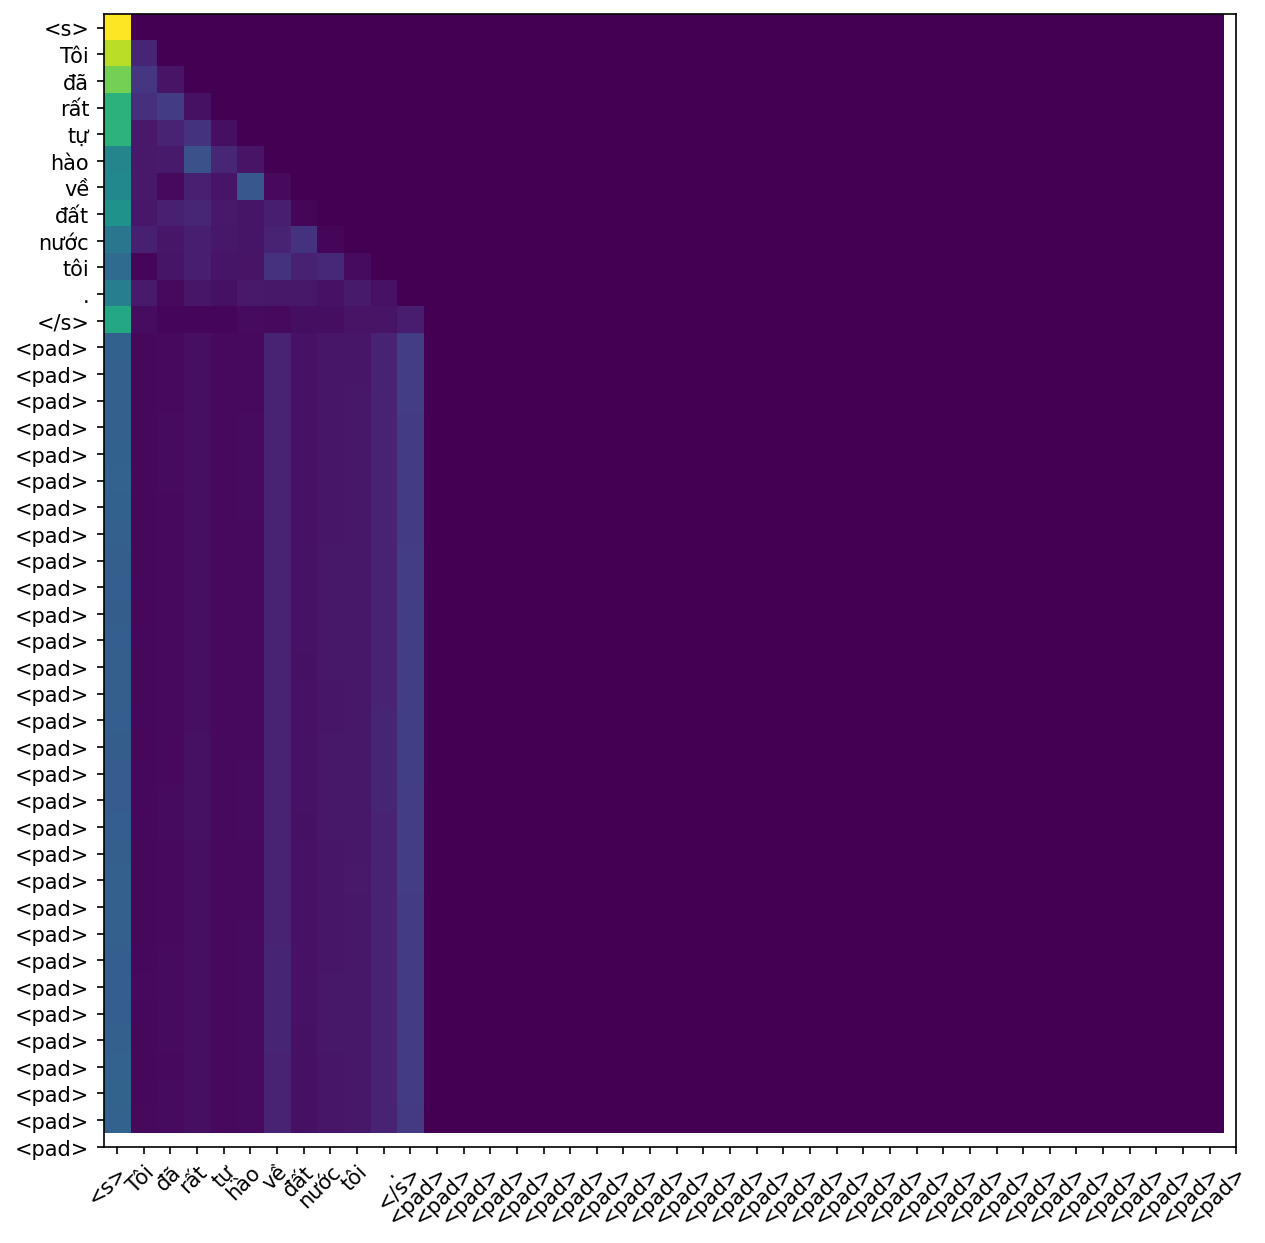

Layer 3
===== Input 0 =====


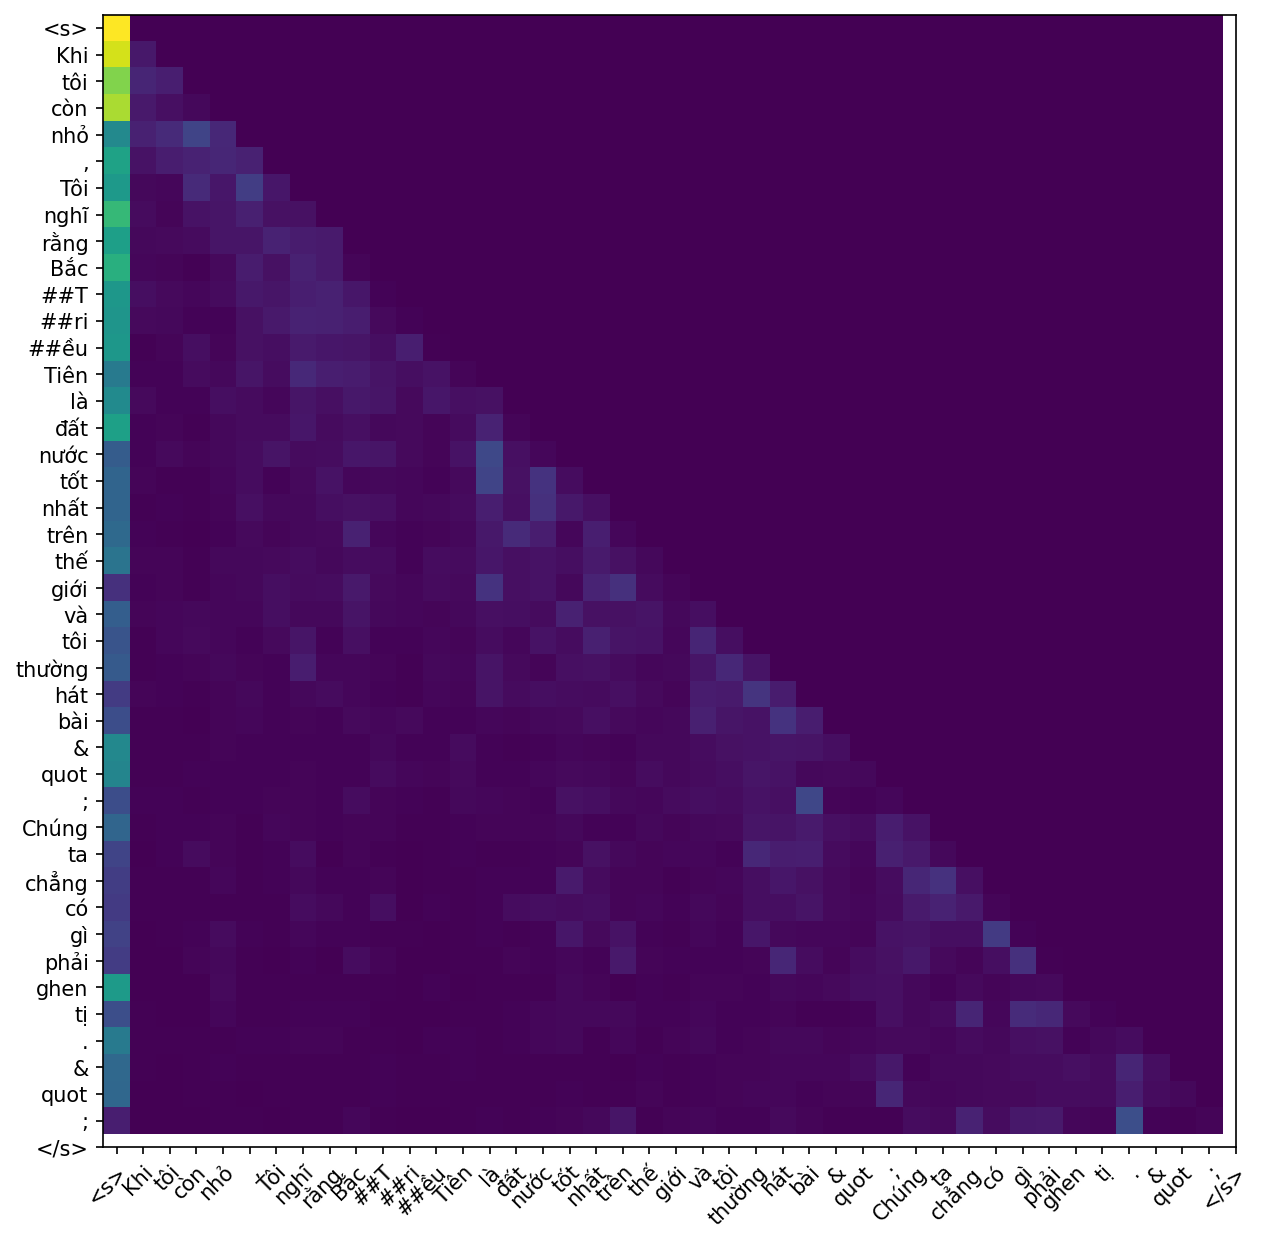

===== Input 1 =====


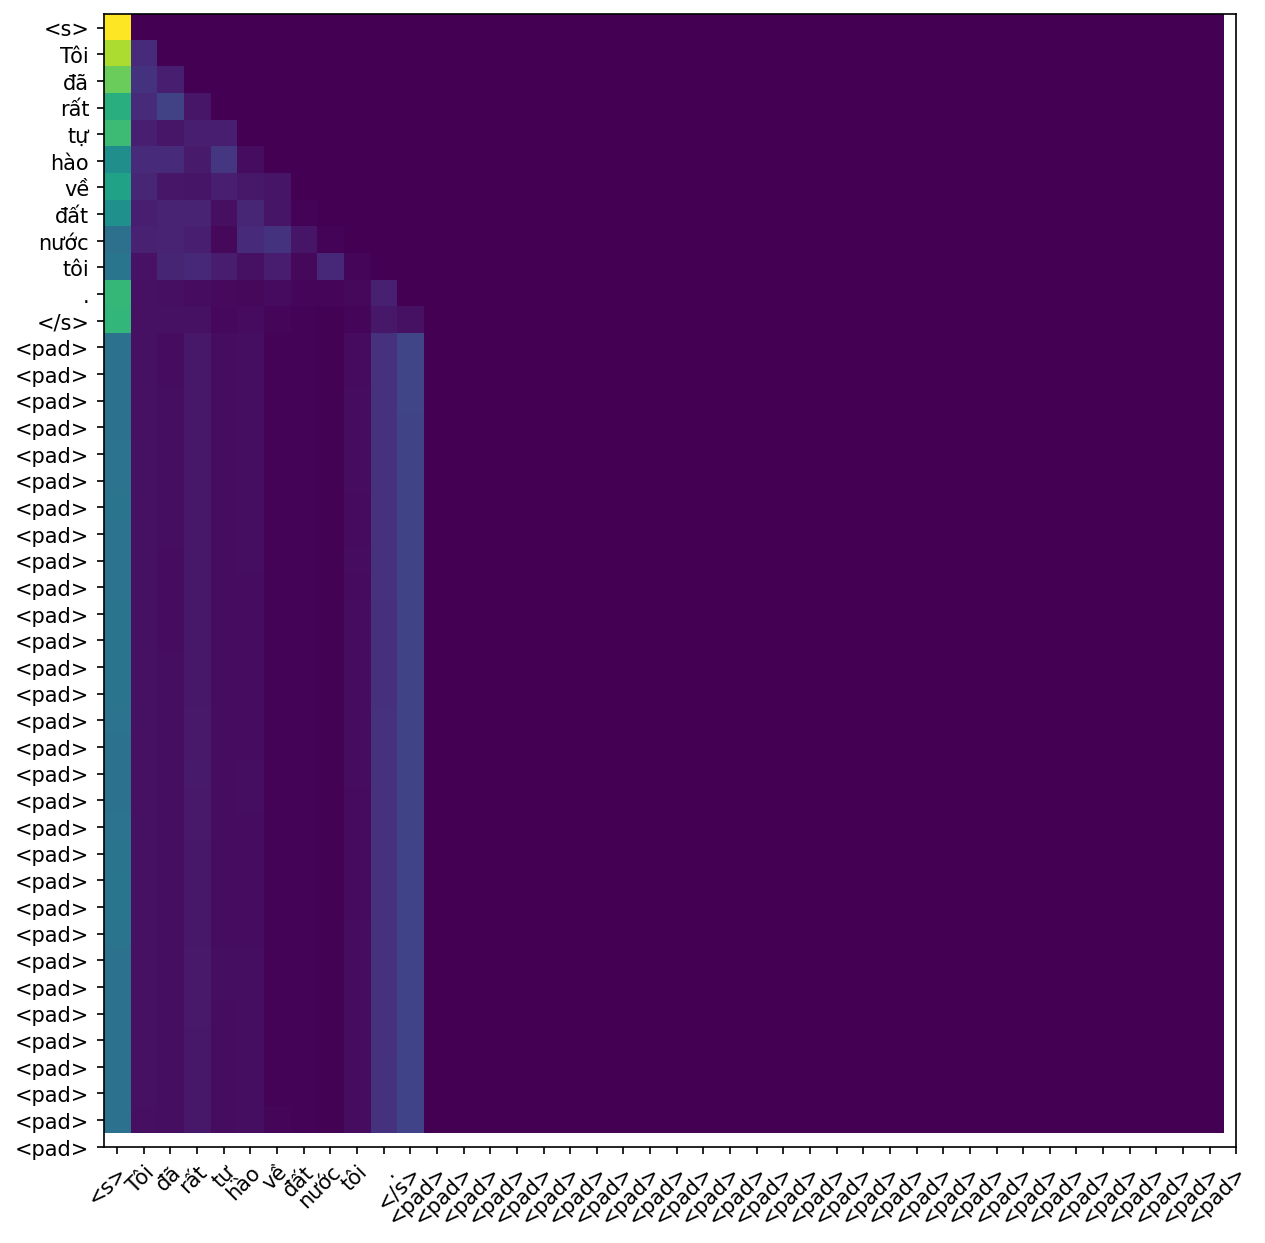

Layer 4
===== Input 0 =====


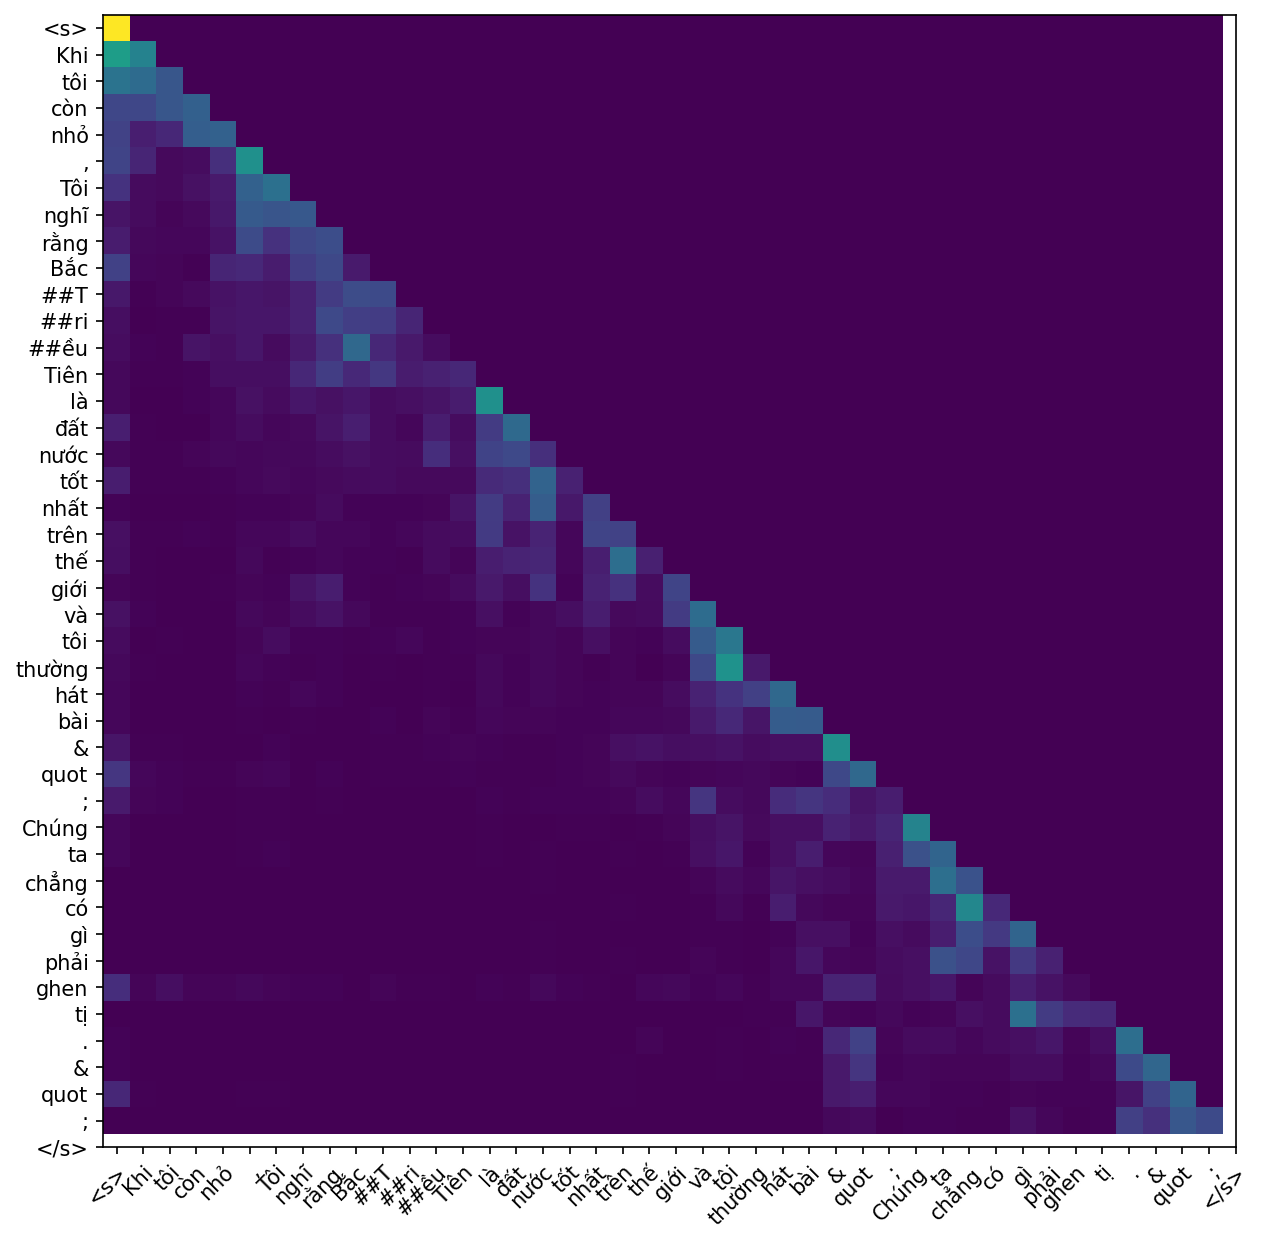

===== Input 1 =====


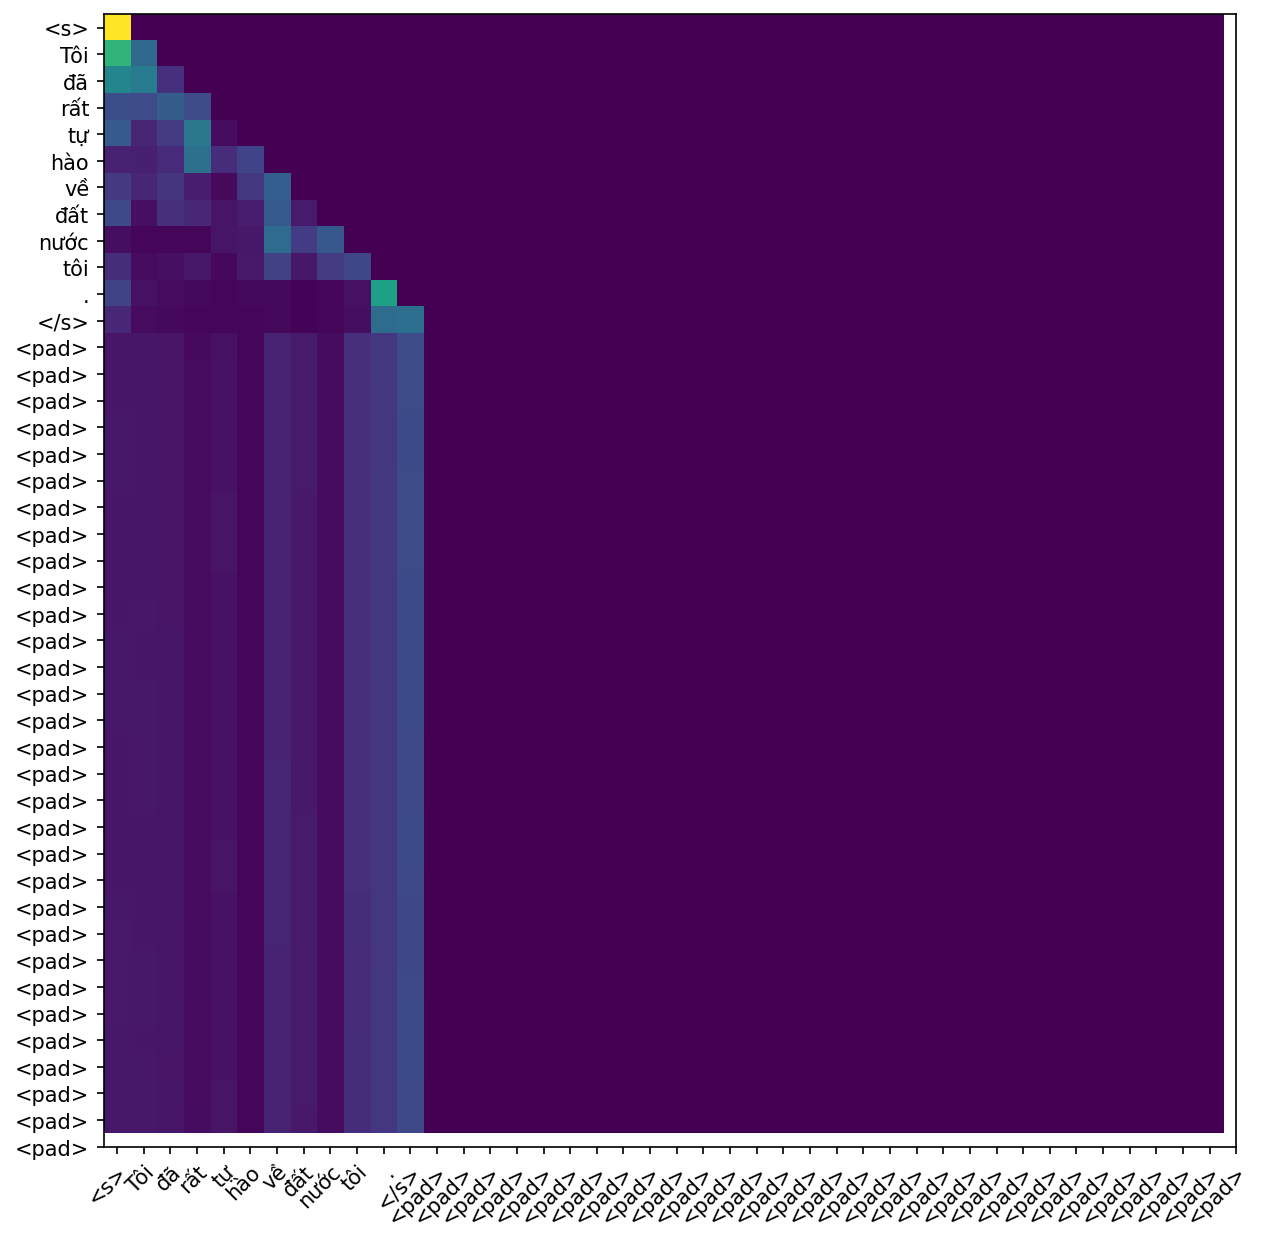

Layer 5
===== Input 0 =====


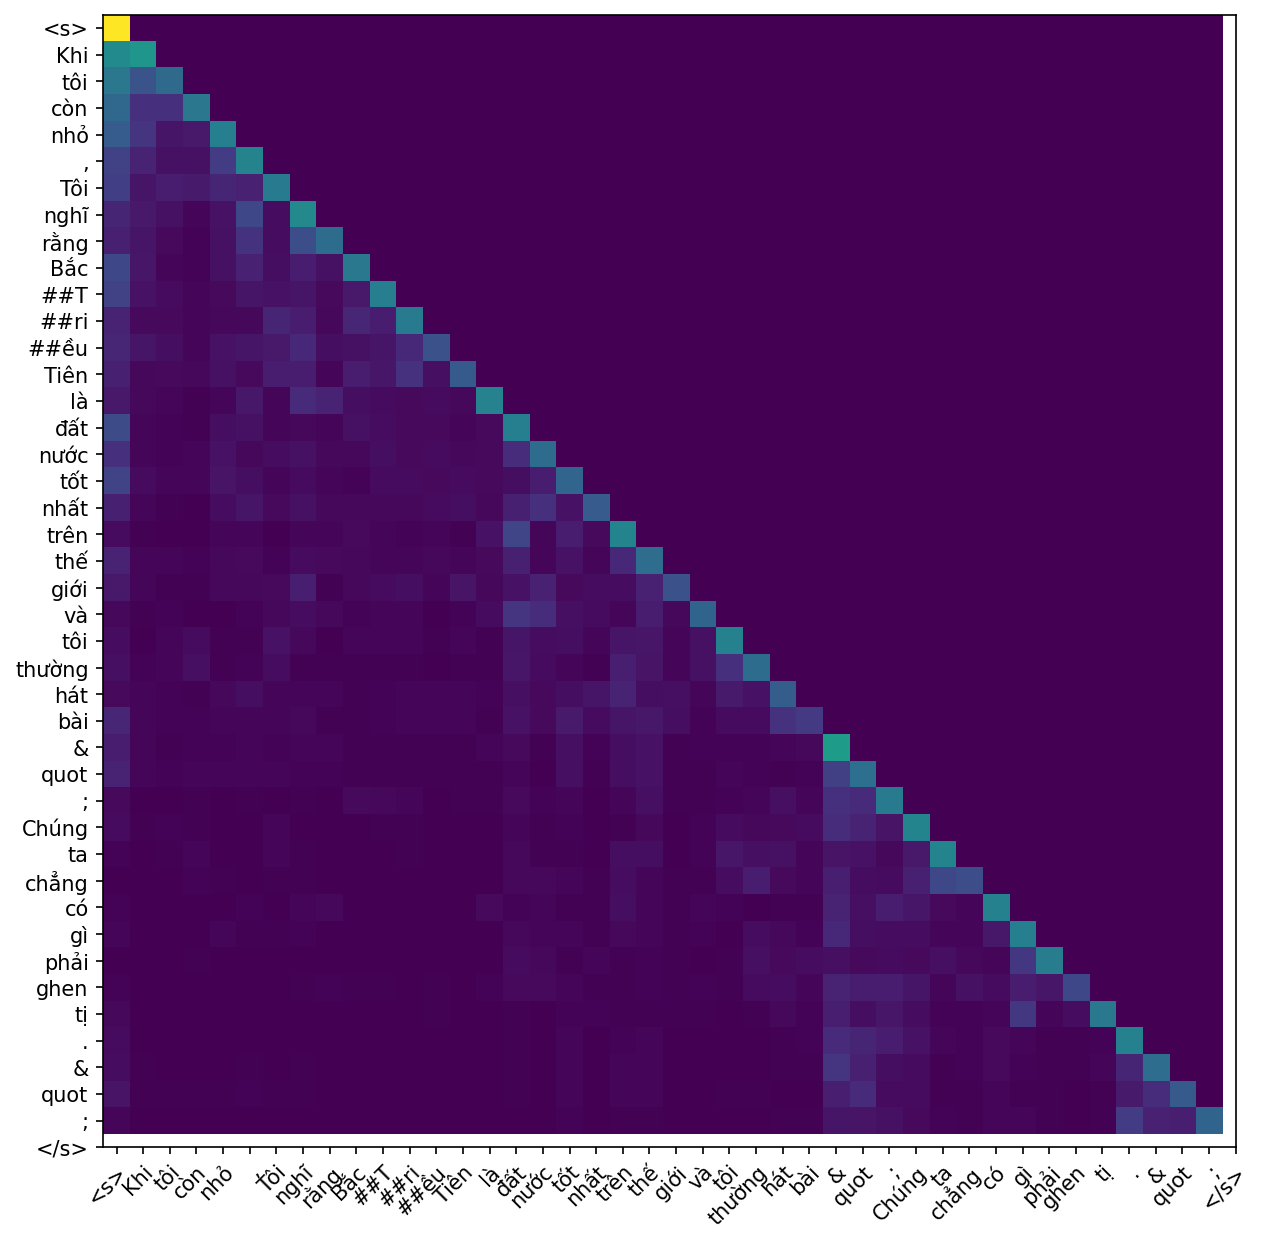

===== Input 1 =====


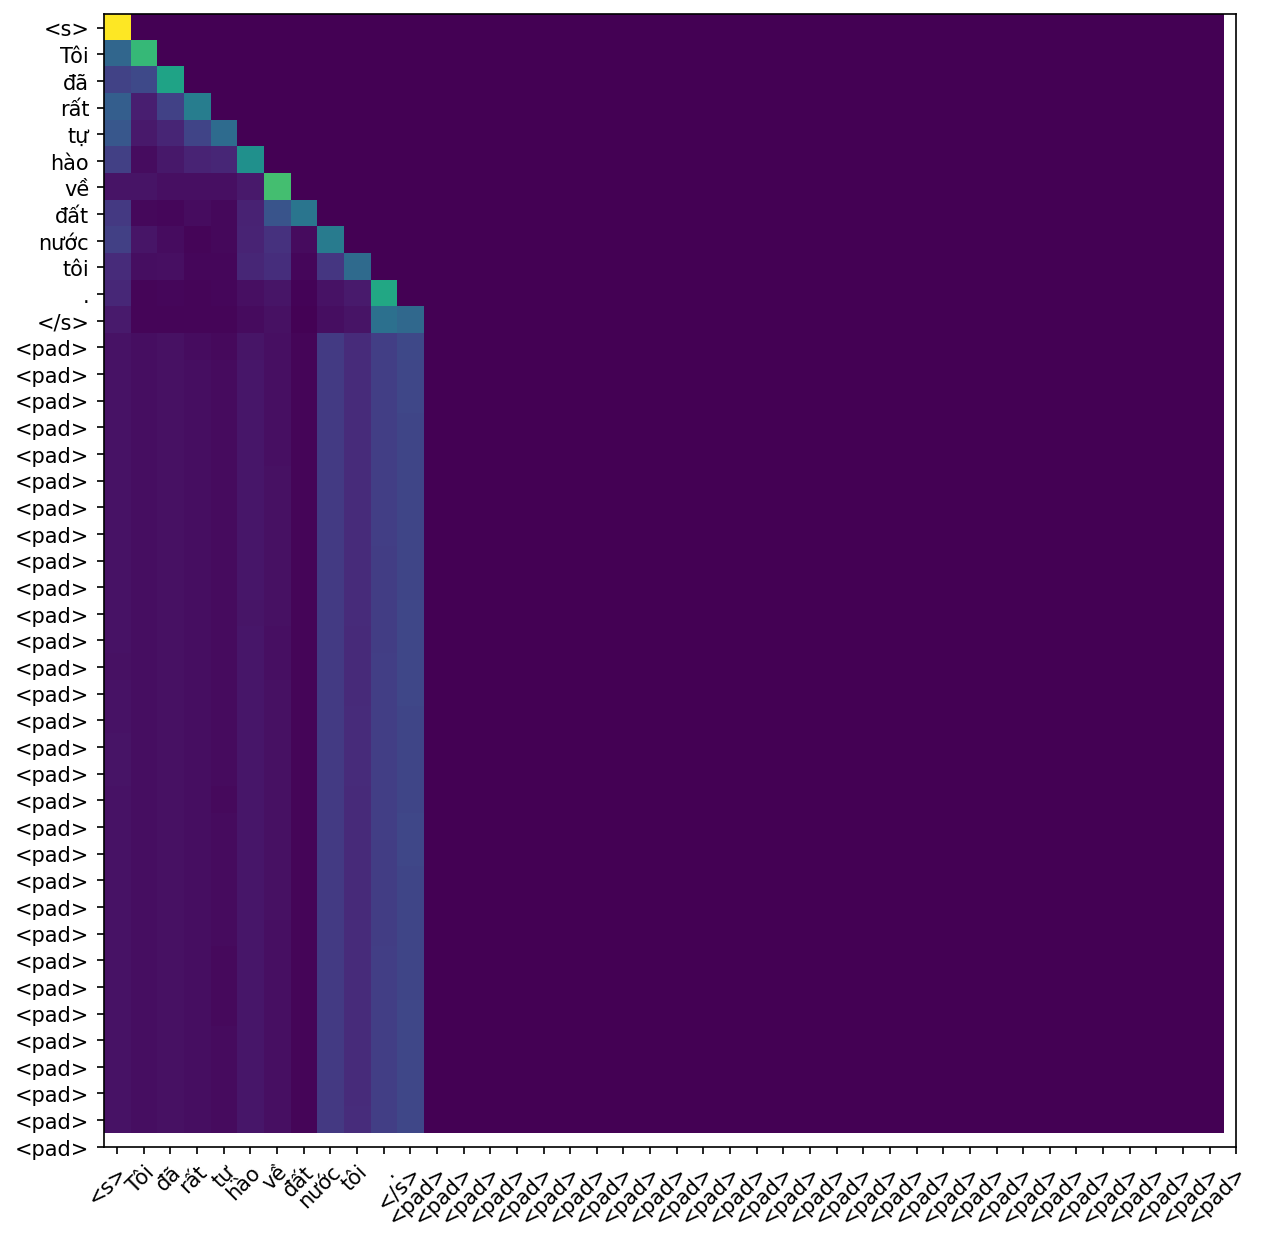

In [11]:
for l in range(len(model.decoder.layer_stack)):
    print(f'Layer {l}')

    handle = model.decoder.layer_stack[l].masked_self_attn.attention.register_forward_hook(visualize_attn_hook)

    for i, (src, trg) in enumerate(dl):
        src_tokens, trg_tokens, pred_tokens = make_prediction(i, src, trg)
        visualize_attn(attn, trg_tokens, trg_tokens)
        break

## **Encoder-Decoder attention**

Layer 0
===== Input 0 =====


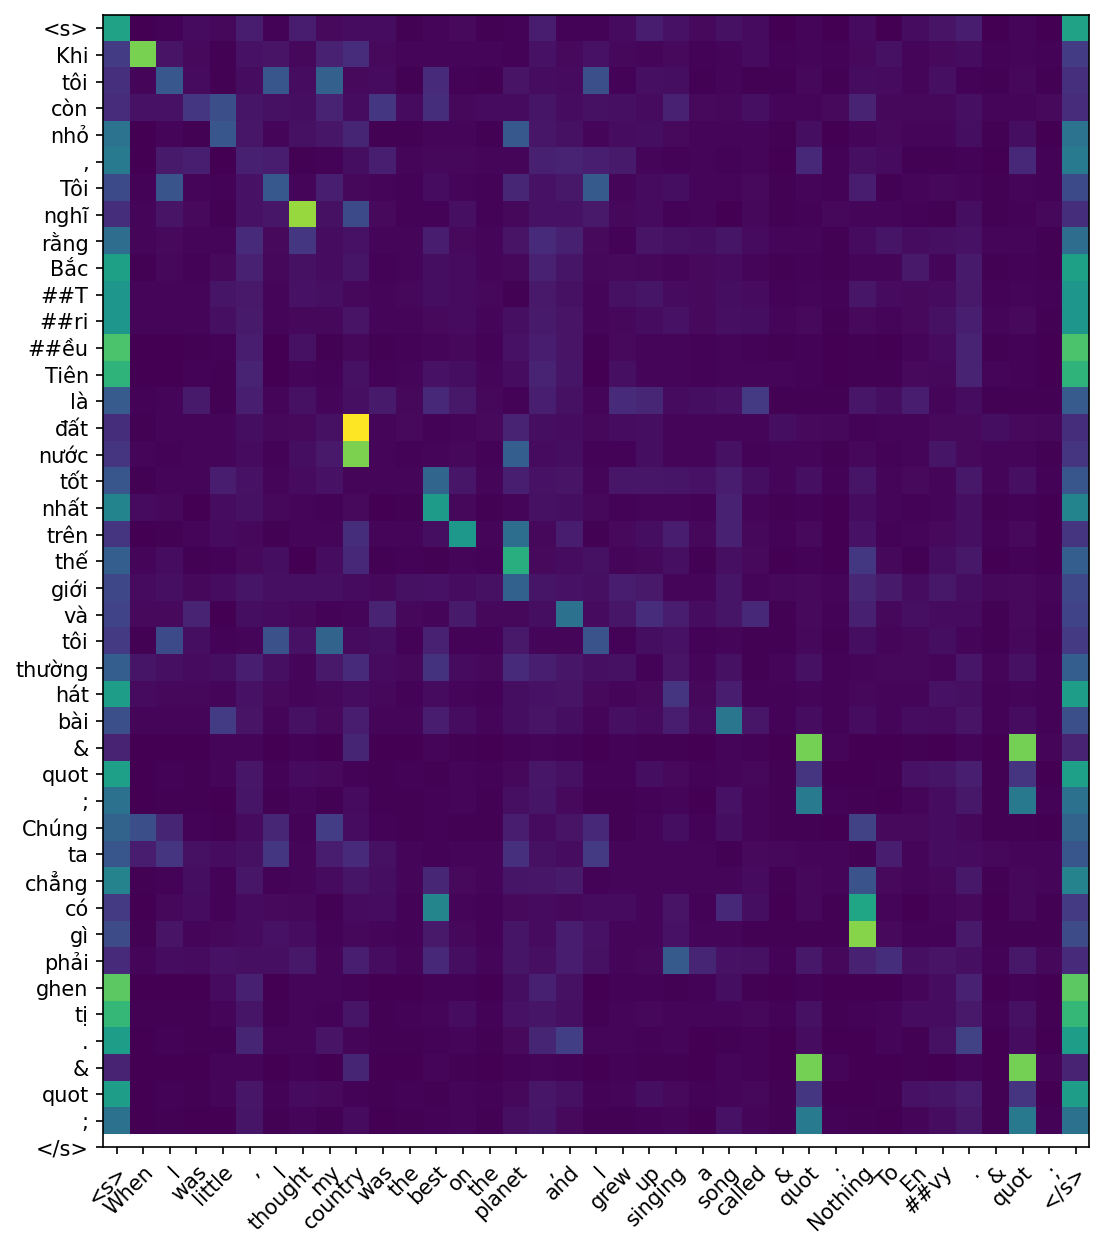

===== Input 1 =====


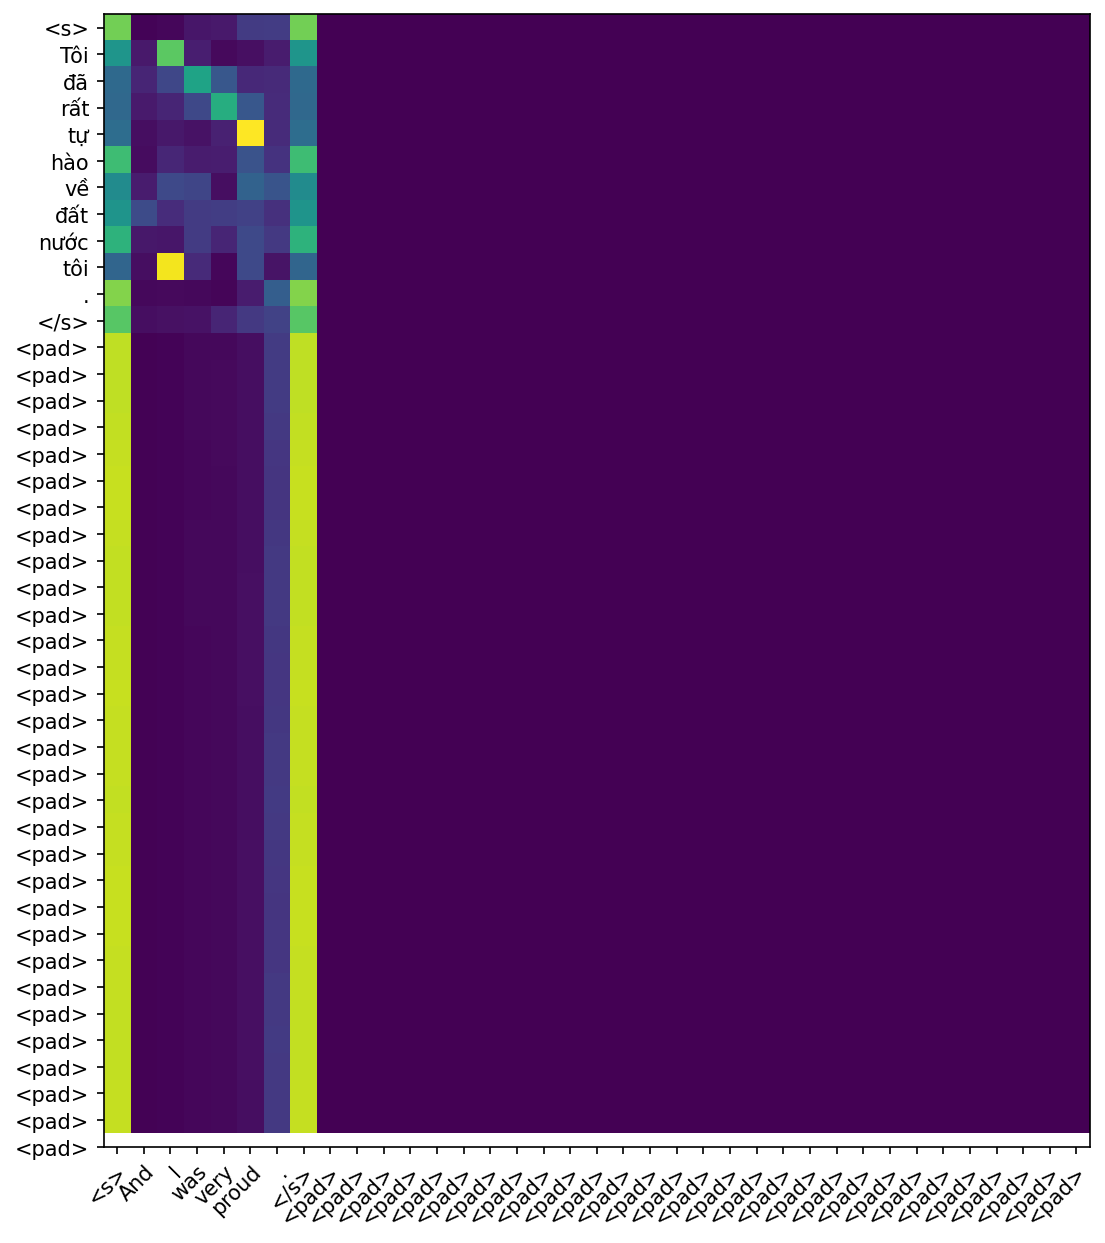

Layer 1
===== Input 0 =====


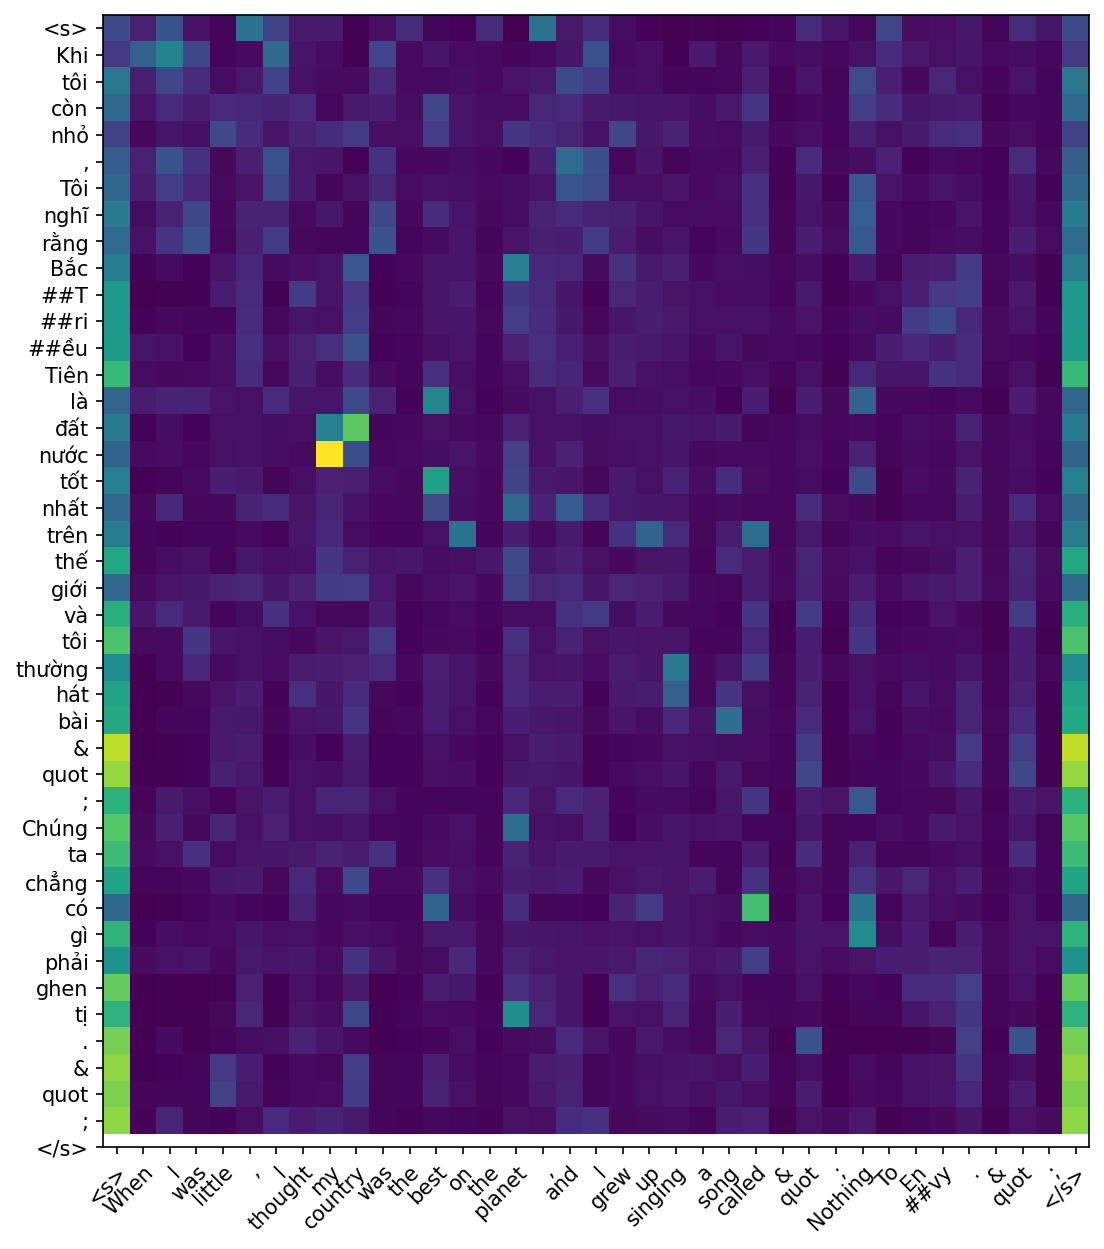

===== Input 1 =====


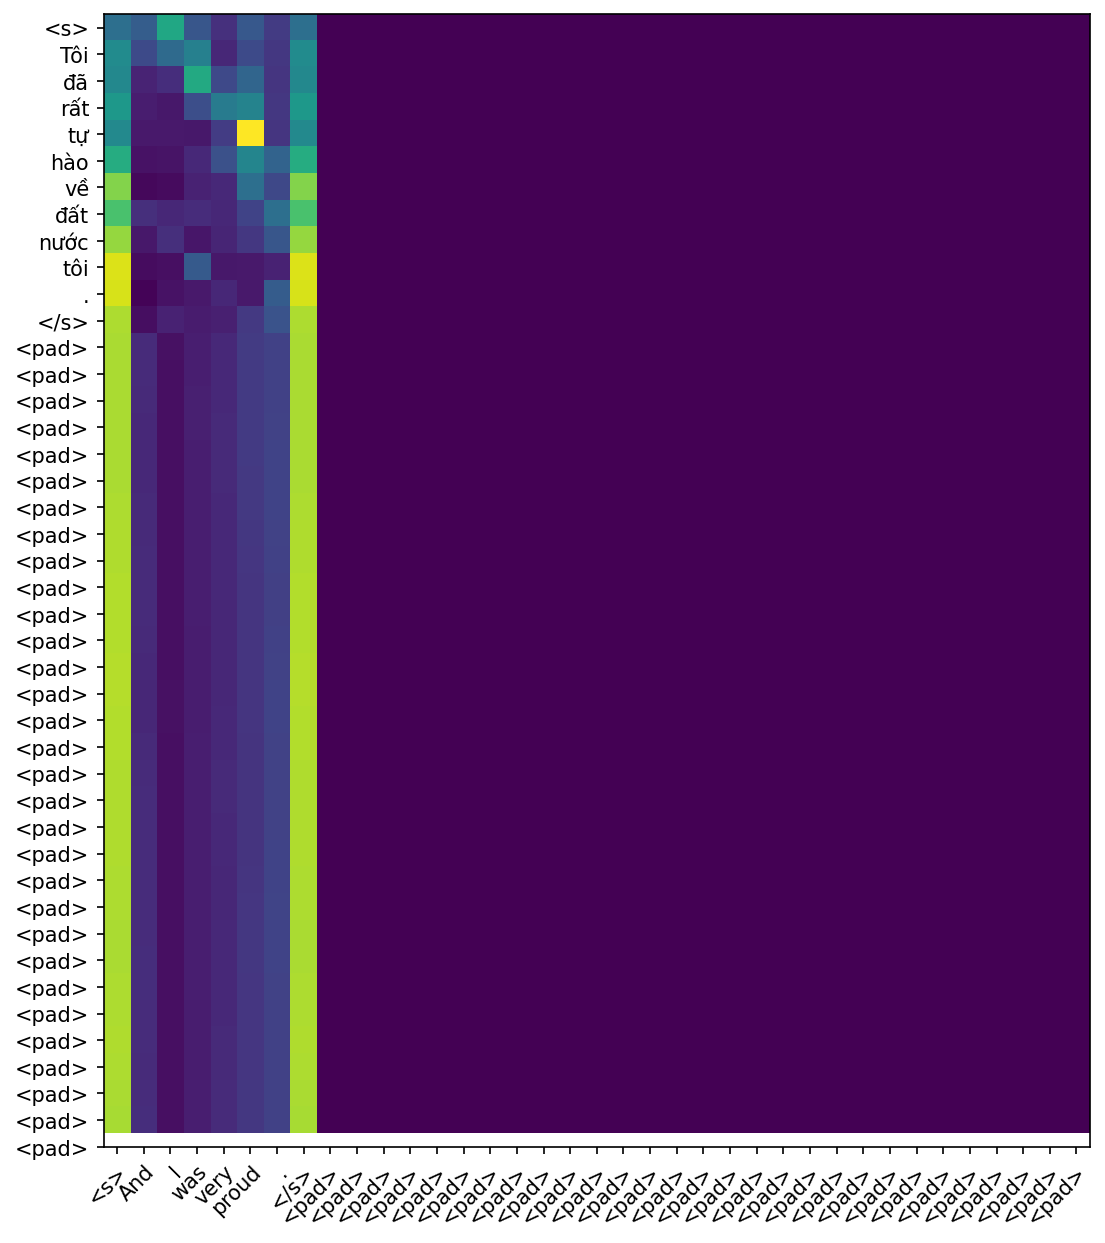

Layer 2
===== Input 0 =====


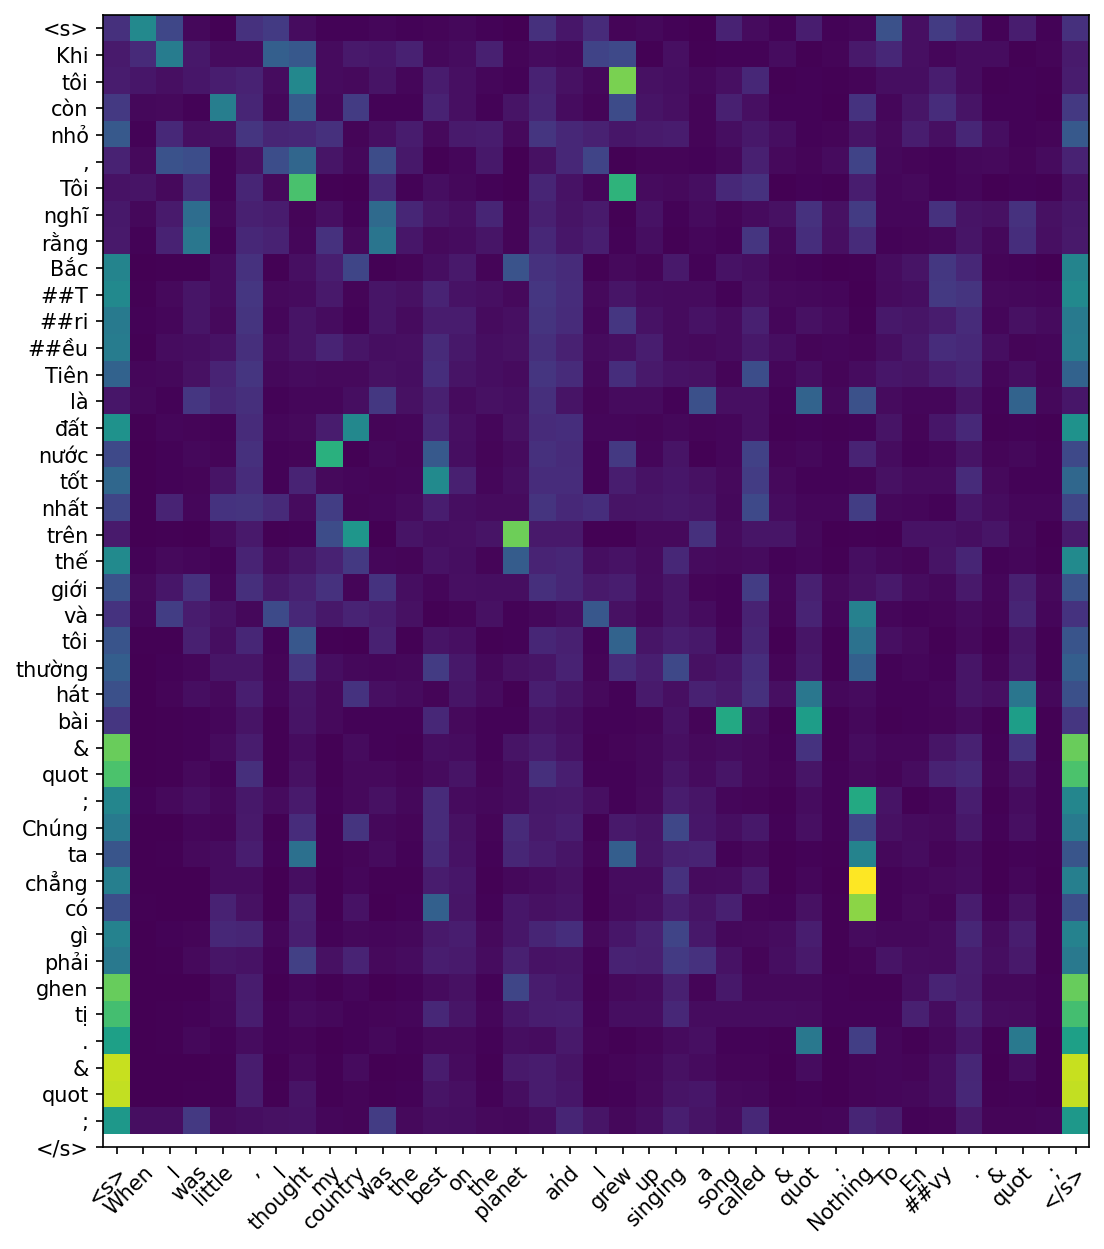

===== Input 1 =====


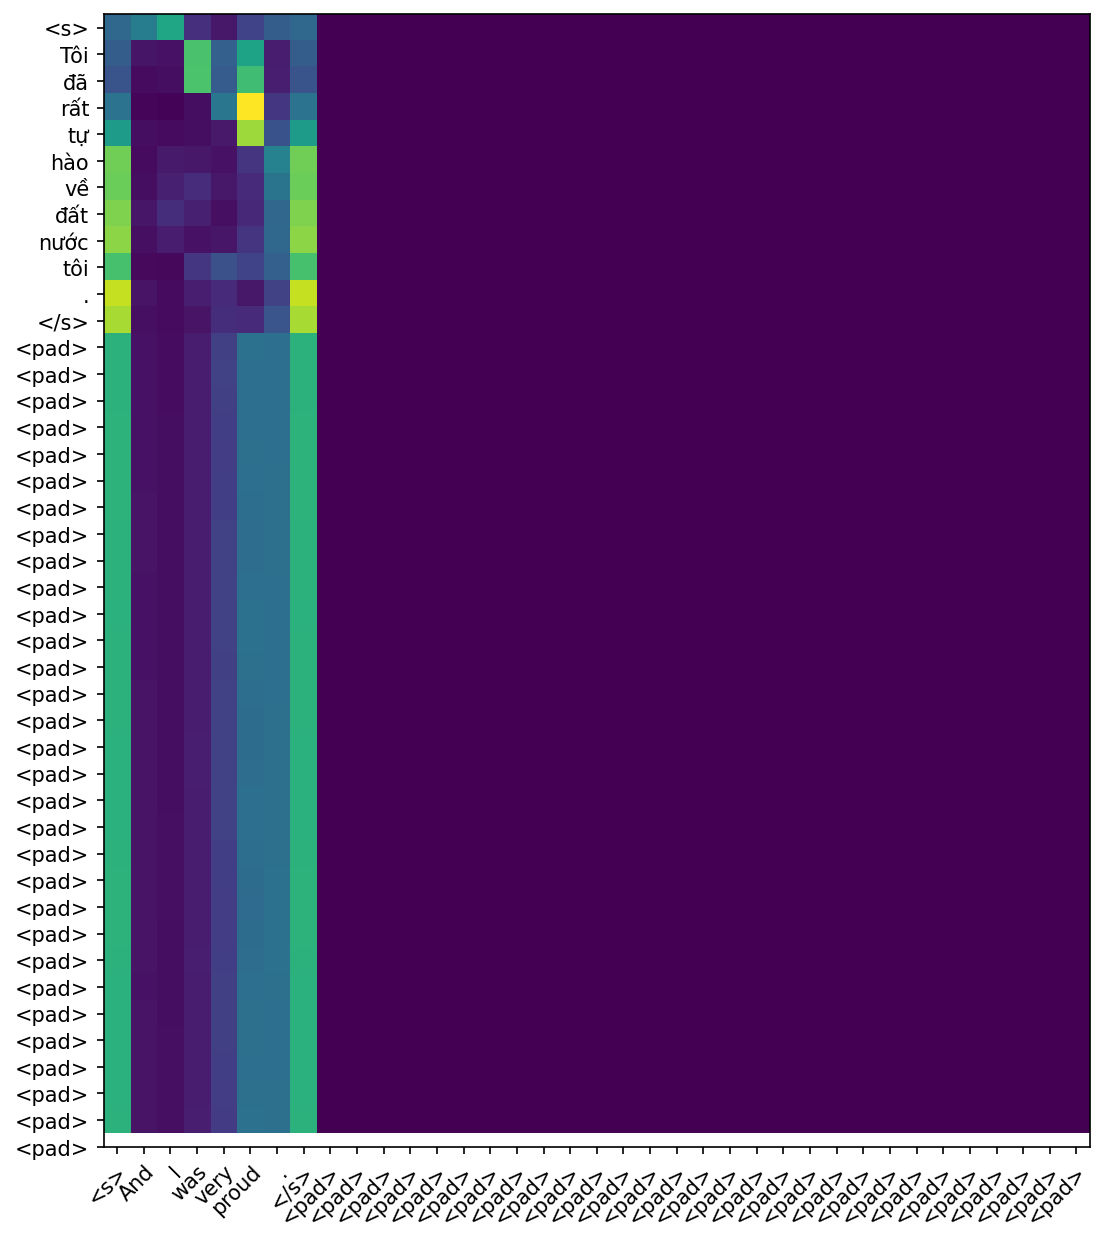

Layer 3
===== Input 0 =====


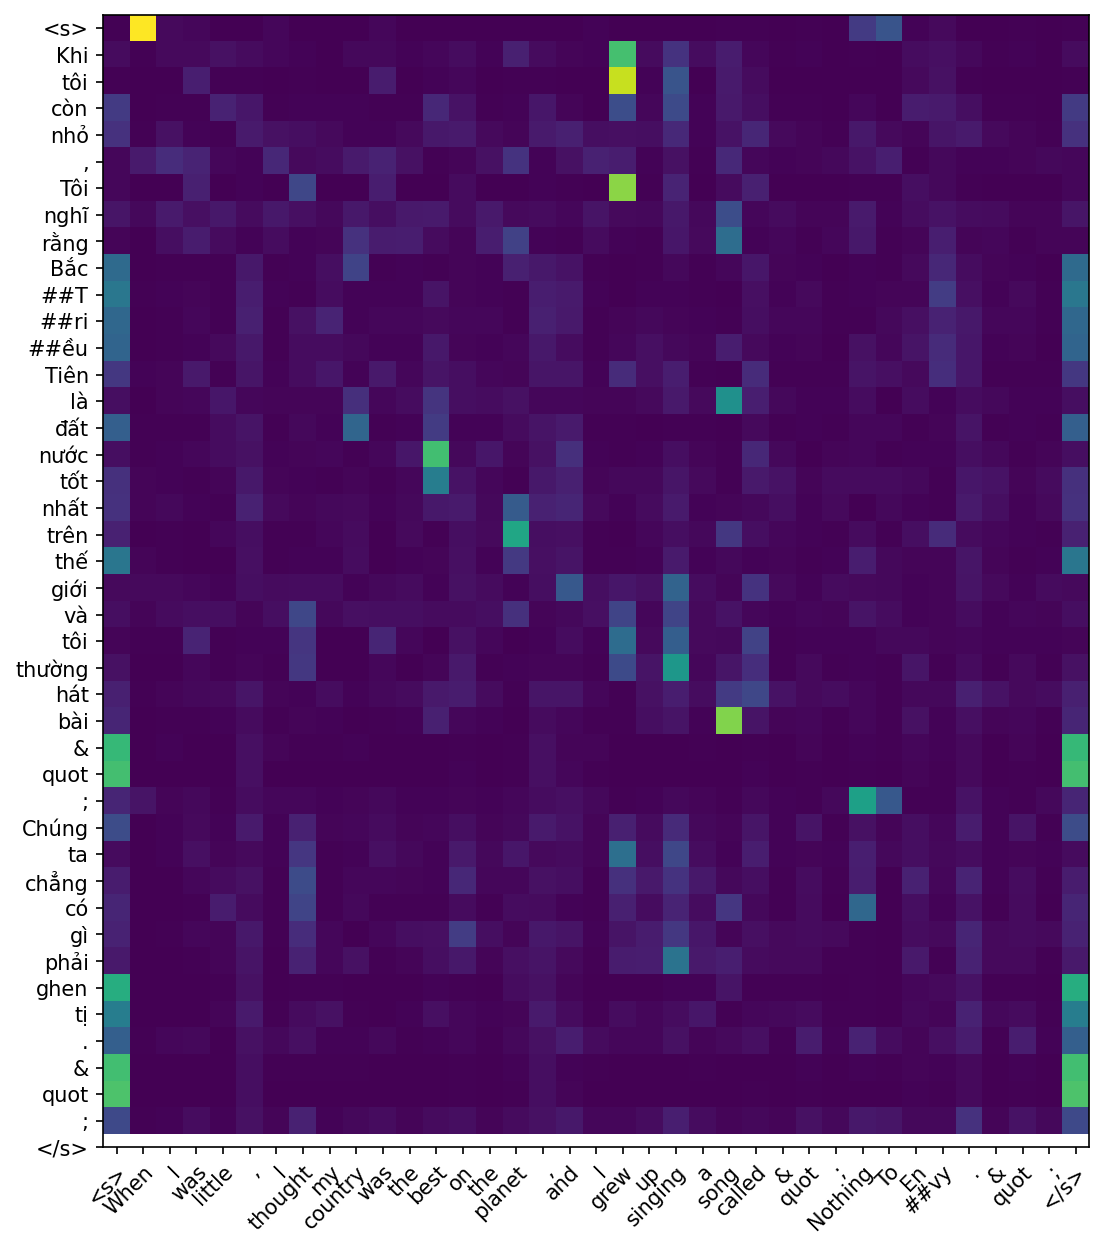

===== Input 1 =====


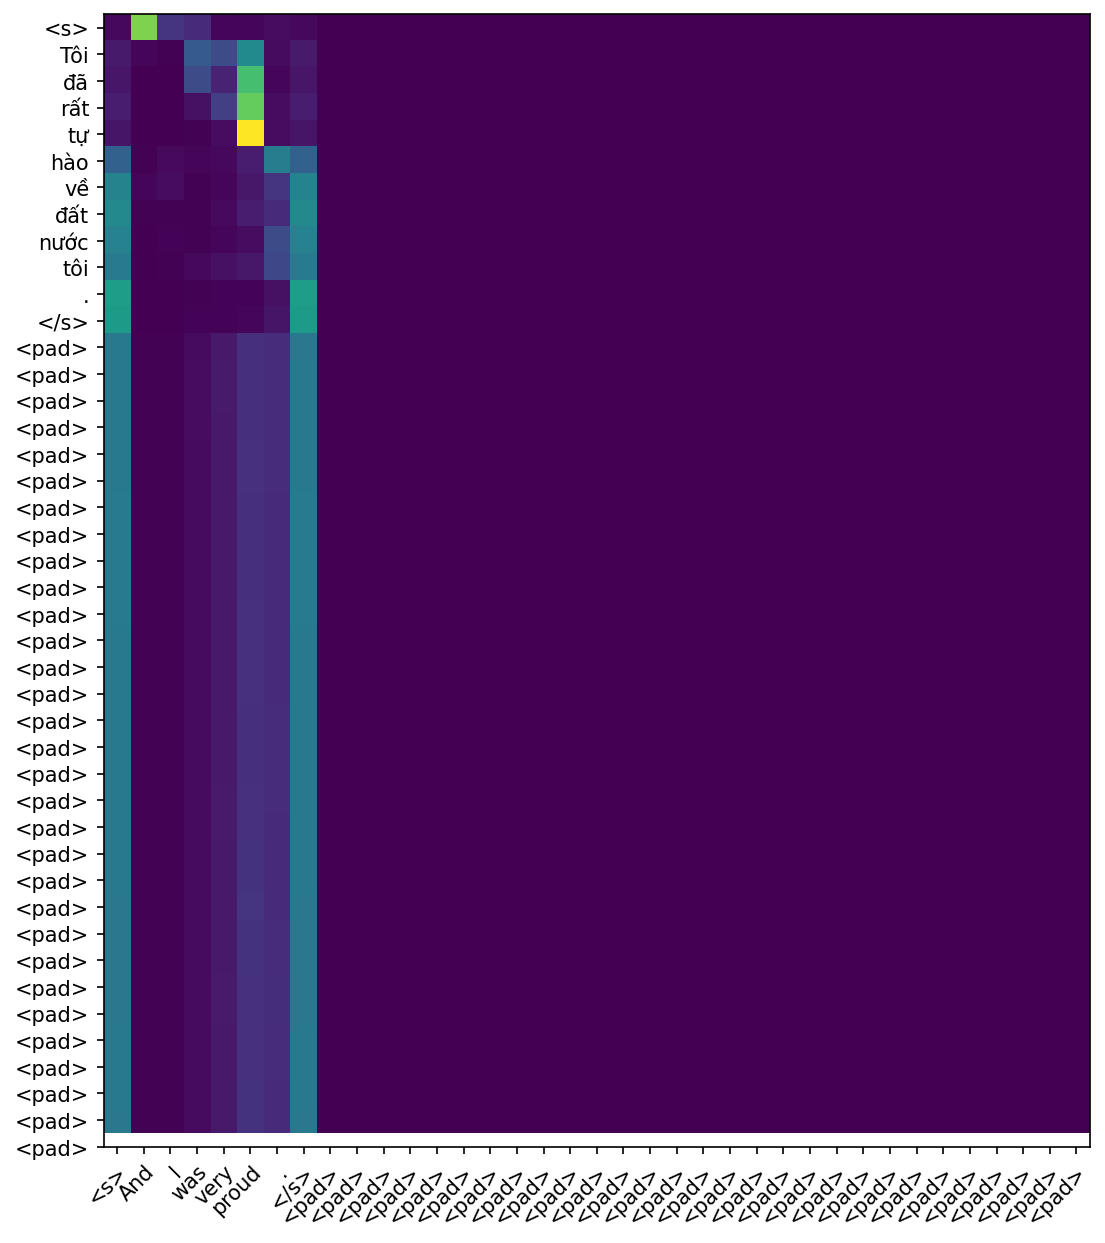

Layer 4
===== Input 0 =====


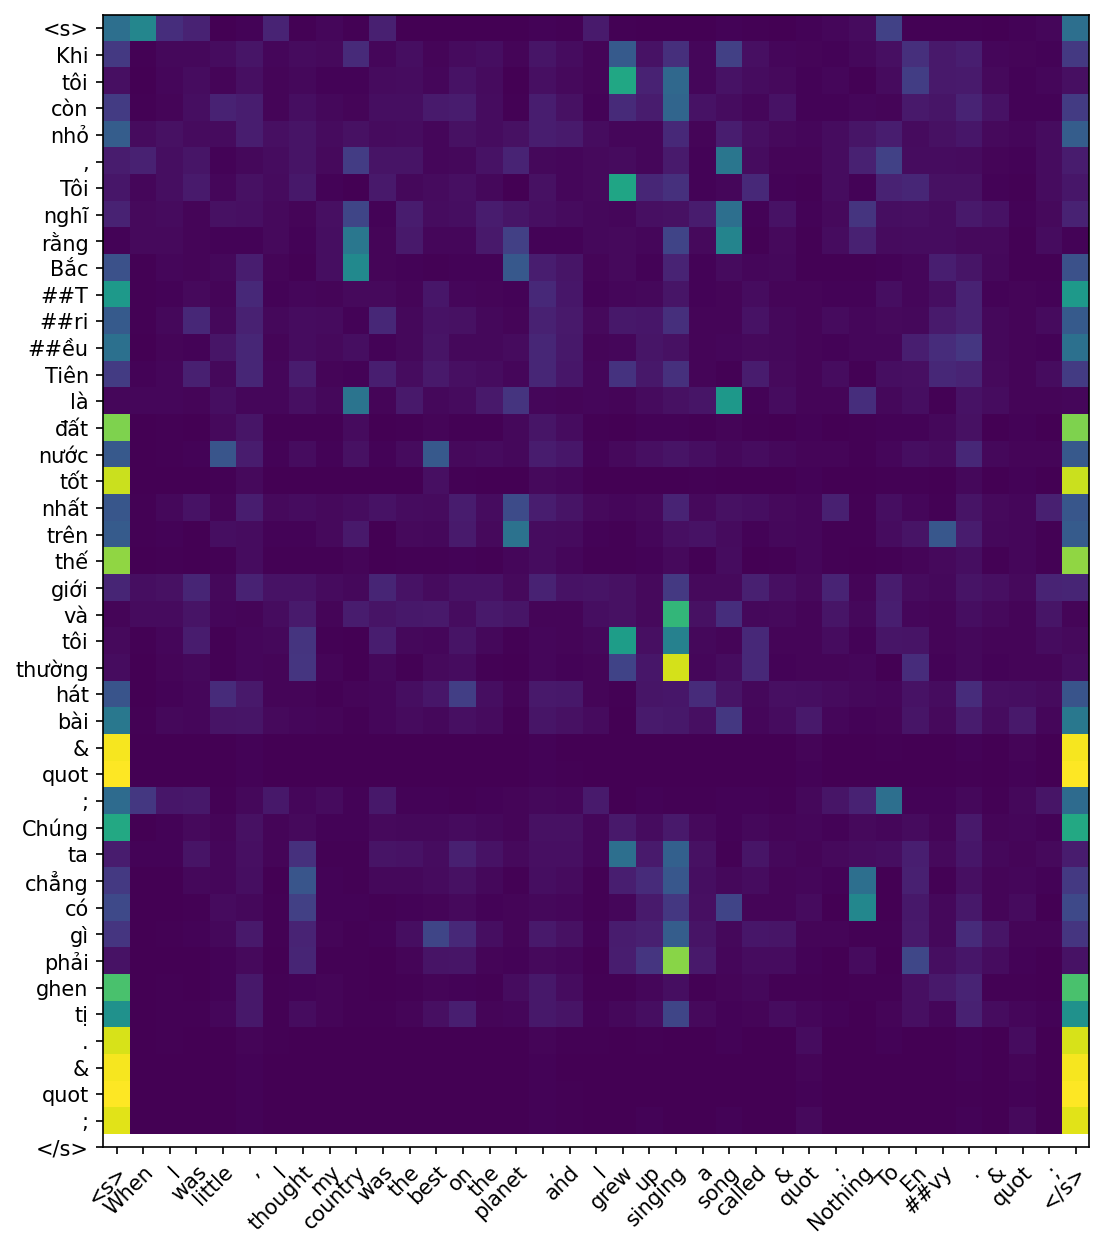

===== Input 1 =====


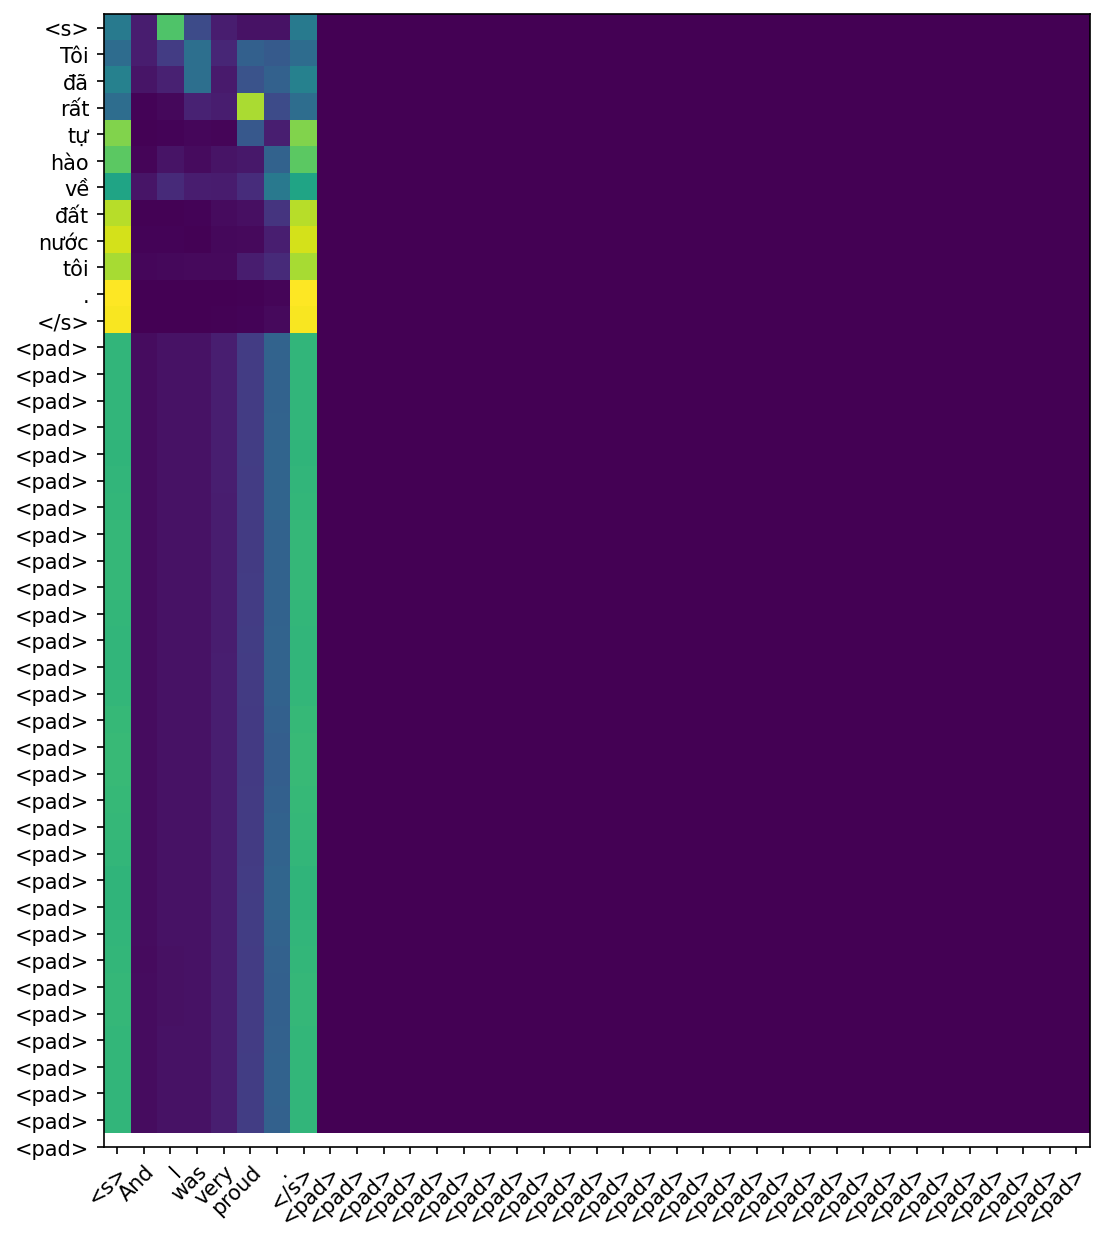

Layer 5
===== Input 0 =====


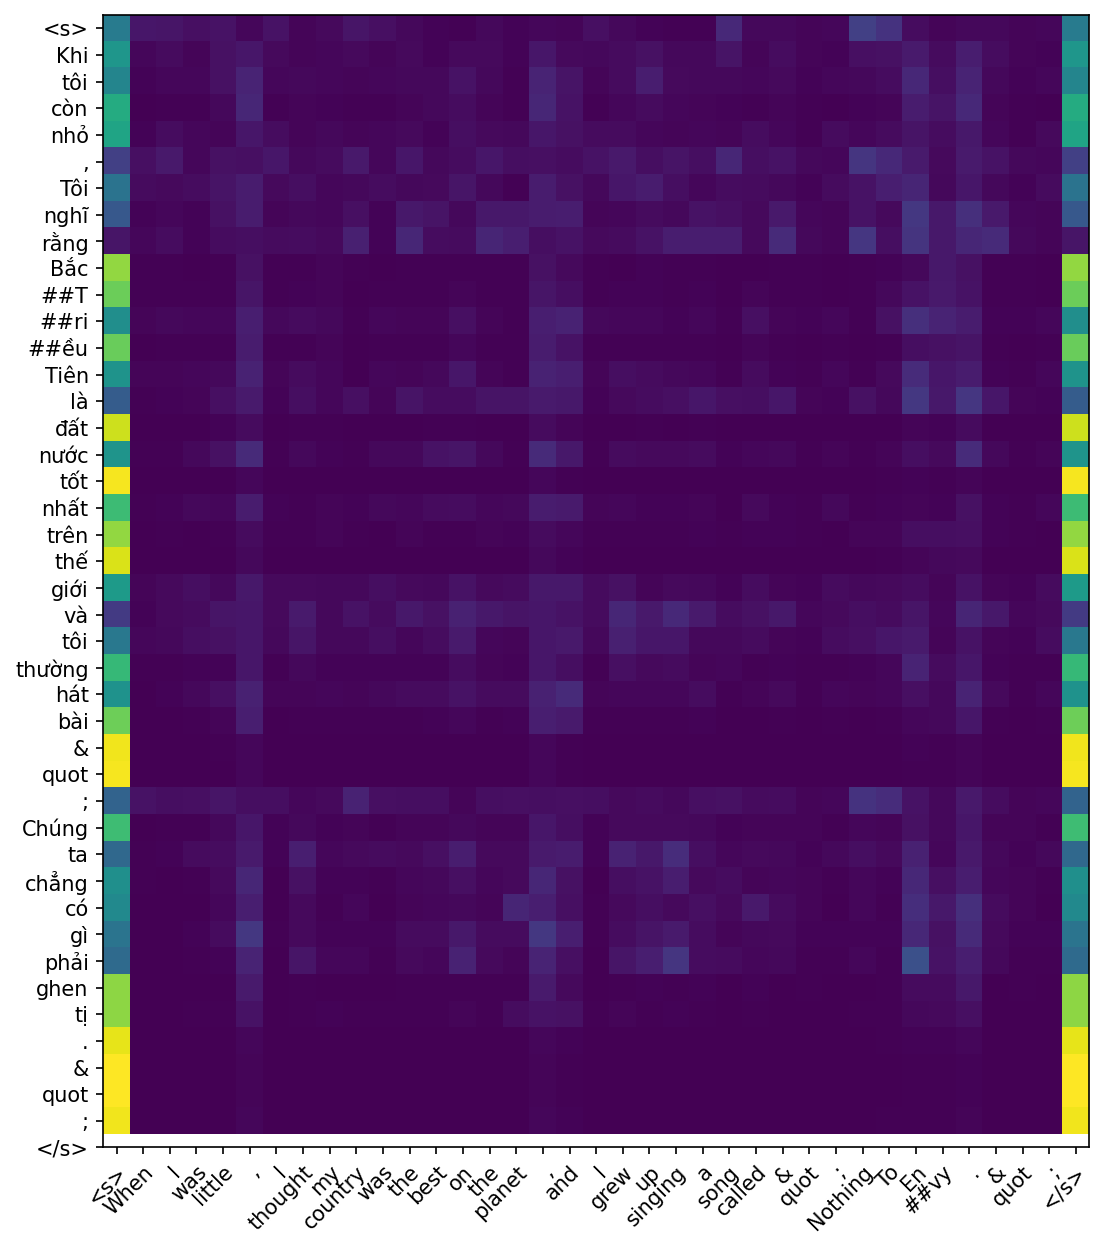

===== Input 1 =====


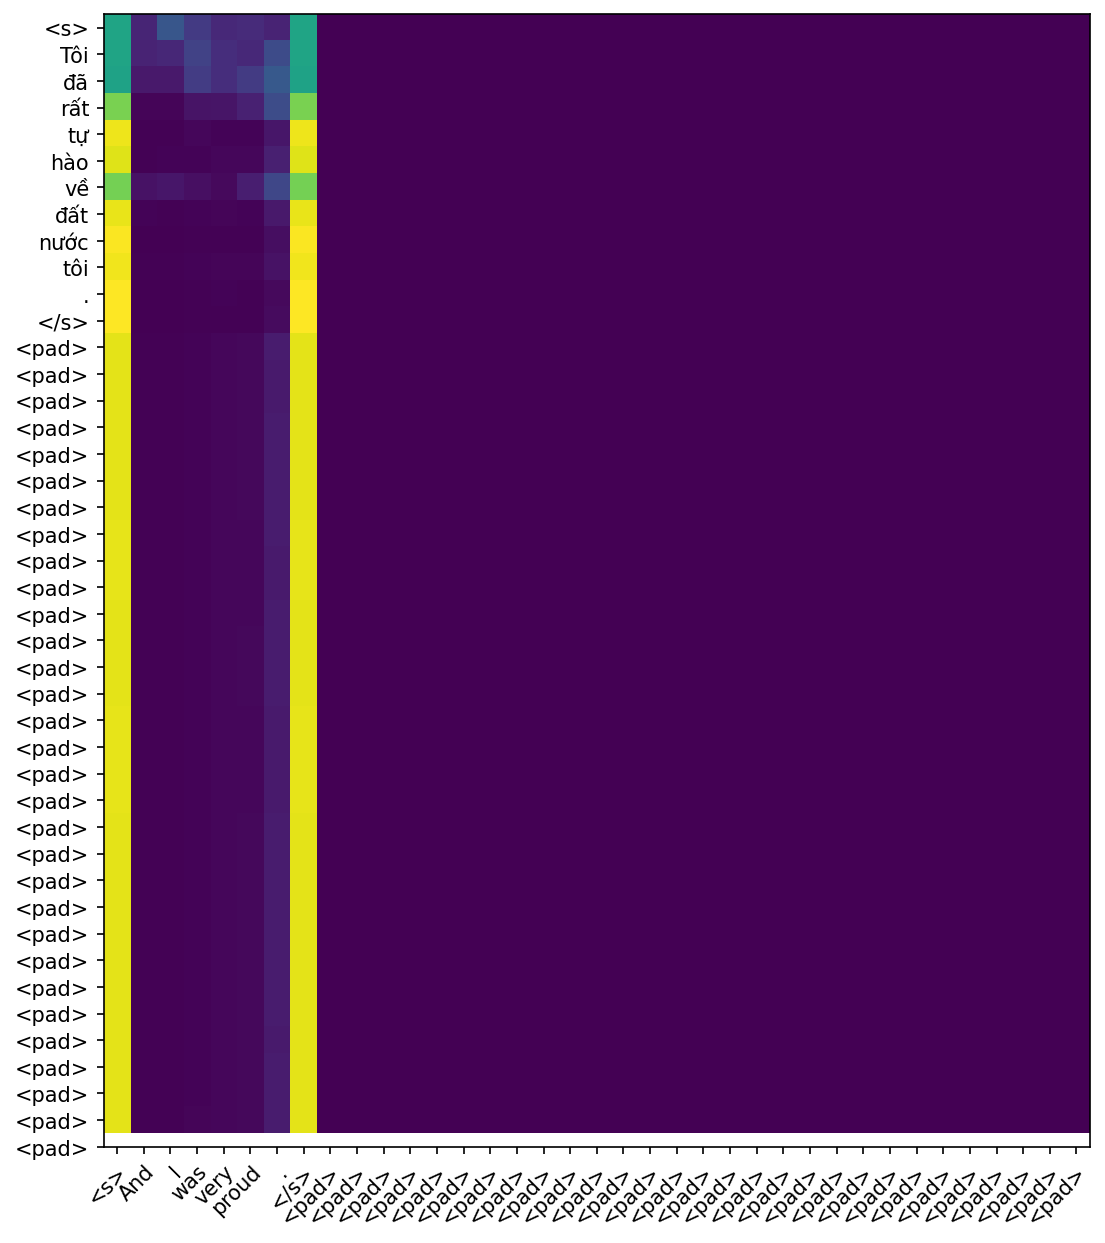

In [12]:
for l in range(len(model.decoder.layer_stack)):
    print(f'Layer {l}')

    handle = model.decoder.layer_stack[l].enc_dec_attn.attention.register_forward_hook(visualize_attn_hook)

    for i, (src, trg) in enumerate(dl):
        src_tokens, trg_tokens, pred_tokens = make_prediction(i, src, trg)
        visualize_attn(attn, src_tokens, trg_tokens)
        break

# **Visualize word embedding**

In [13]:
seq = 'Today is the first day of school'

x = torch.LongTensor(ds.en_tokenizer.encode(seq).ids).unsqueeze(0)
x_word_emb = model.enc_emb.word_emb(x)
print('Word embedding:\n', x_word_emb)
print('Total embedding:\n', model.enc_emb(x))

Word embedding:
 tensor([[[ 0.6105,  0.2874,  0.8427,  ...,  0.1347,  0.3652, -0.1595],
         [-1.8058, -1.4480, -1.0547,  ...,  2.4244, -0.0172,  1.1556],
         [-0.9691,  0.9660,  1.7670,  ...,  1.0234, -0.7780, -1.7299],
         ...,
         [ 0.2852, -0.0181, -0.7791,  ...,  0.2753, -0.2121, -0.4138],
         [-1.6300,  0.3888, -0.3976,  ...,  0.8293, -1.1098, -0.0265],
         [ 1.1430, -0.2835, -0.5068,  ...,  0.5016, -0.6544,  0.9560]]],
       grad_fn=<EmbeddingBackward>)
Total embedding:
 tensor([[[ 13.8132,   7.5035,  19.0673,  ...,   4.0490,   8.2628,  -2.6099],
         [-40.0202, -32.2234, -23.0422,  ...,  55.8580,  -0.3896,  27.1474],
         [-21.0179,  21.4430,  40.9194,  ...,  24.1568, -17.6049, -38.1423],
         ...,
         [  6.1734,   0.5499, -18.1052,  ...,   7.2295,  -4.7977,  -8.3643],
         [-36.2249,   9.5507,  -8.5448,  ...,  19.7644, -25.1121,   0.4007],
         [ 26.8514,  -6.5597, -10.4776,  ...,  12.3498, -14.8072,  22.6326]]],
       gr

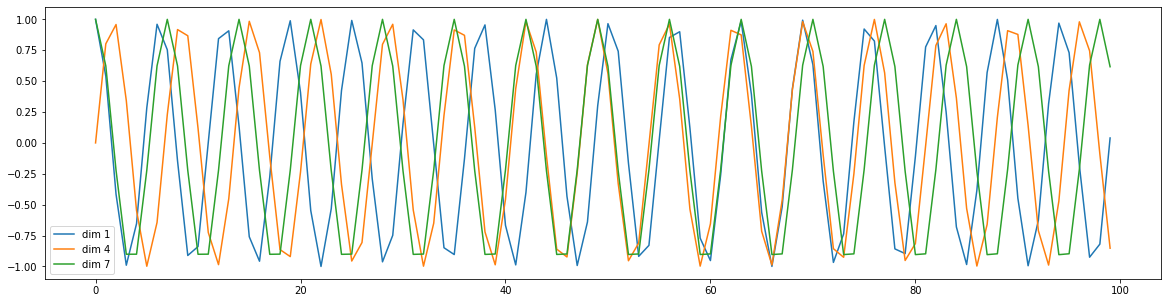

In [14]:
L = 100
D = [1, 4, 7]

plt.figure(figsize=(20, 5))
plt.plot(range(L), model.enc_emb.pe[0, :L, D])
plt.legend(["dim %d"%p for p in D])
plt.show()

In [15]:
from tqdm import tqdm

PAD_IDX = 1

with torch.no_grad():
    trgs, preds = [], []
    bar = tqdm(dl)
    n_word_total, n_word_correct = 0., 0.
    score = 0.
    for i, (src, trg) in enumerate(bar):
        bar.set_description(f'Accuracy: {score:.06f}')

        src = src.to(dev)
        trg = trg.to(dev)

        trg_ = trg.cpu()[:, 1:]
        pred_ = model(src, trg[:, :-1]).argmax(-1).cpu()

        n_correct = pred_.eq(trg_)
        n_correct = torch.where(trg_.eq(PAD_IDX), torch.zeros_like(n_correct), n_correct).sum().item()

        n_word = trg_.ne(PAD_IDX).sum().item()
        n_word_total += n_word
        n_word_correct += n_correct

        score = n_word_correct / n_word_total

    print('Final', score)

Accuracy: 0.472181: 100%|██████████| 634/634 [00:18<00:00, 34.76it/s]

Final 0.47207122254271133
